Data Analysis Template for PAX Data
===============================================
Authored by: [Nathan Belmore](https://plasma.physics.berkeley.edu/faculty-staff/nathan-belmore) 

Published: 9.1.2019

Current working version: V0.1

Change Log:



To do: 


# Analysis
***



In [60]:
# creating the correct enviroment for analysis
import os
import re
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import argrelextrema, savgol_filter
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit.models import BreitWignerModel

# Setting parameters to make plots clear for publication
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

# Importing the data

In [7]:
# path to the data set
path = '27/'

# some data structure for genetrating a list of the files. 
files = []

for file in os.listdir(path):
    if file.endswith(".txt"):
        files.append(file)
files.sort()
print('Files imported:')

# Importing the data in a pandas dataframe

dfs = []
names=['time', 'ch1', 'ch2', 'ch3', 'ch4']
index = []

for num, fname in enumerate(files, start=1):
    print("File #{} | {}".format(num - 1, fname))
    if len(fname) > 0:
        pathname = os.path.join(path, fname)
        data = pd.read_table(pathname, index_col='time', sep='\t', names=names)
        dfs.append(data)
        index.append([int(s) for s in re.findall(r'\d+', fname)][-3:])

index = pd.DataFrame(index, columns=['eV', 'delay', 'iter'])
data = pd.Series(dfs)
# df = pd.concat(dfs, keys=[f'set {i}' for i in range(1,len(dfs)+1)], names=['Set Number'], axis=1)

Files imported:
File #0 | Scope_27.09.2018_23.36.15_20eV_delay_020_msec__0.txt
File #1 | Scope_27.09.2018_23.37.30_20eV_delay_020_msec__1.txt


/home/natephysics/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead.


File #2 | Scope_27.09.2018_23.38.45_20eV_delay_020_msec__2.txt
File #3 | Scope_27.09.2018_23.39.59_20eV_delay_020_msec__3.txt
File #4 | Scope_27.09.2018_23.41.14_20eV_delay_020_msec__4.txt
File #5 | Scope_27.09.2018_23.42.28_20eV_delay_020_msec__5.txt
File #6 | Scope_27.09.2018_23.43.43_20eV_delay_020_msec__6.txt
File #7 | Scope_27.09.2018_23.44.57_20eV_delay_020_msec__7.txt
File #8 | Scope_27.09.2018_23.46.12_20eV_delay_020_msec__8.txt
File #9 | Scope_27.09.2018_23.47.26_20eV_delay_020_msec__9.txt
File #10 | Scope_27.09.2018_23.48.41_20eV_delay_020_msec__10.txt
File #11 | Scope_27.09.2018_23.49.55_20eV_delay_020_msec__11.txt
File #12 | Scope_27.09.2018_23.51.10_20eV_delay_020_msec__12.txt
File #13 | Scope_27.09.2018_23.52.24_20eV_delay_020_msec__13.txt
File #14 | Scope_27.09.2018_23.53.39_20eV_delay_020_msec__14.txt
File #15 | Scope_27.09.2018_23.54.53_20eV_delay_020_msec__15.txt
File #16 | Scope_27.09.2018_23.56.09_20eV_delay_050_msec__0.txt
File #17 | Scope_27.09.2018_23.57.28_20eV_

## Selecting the data range

Below we will automate some of the data selection

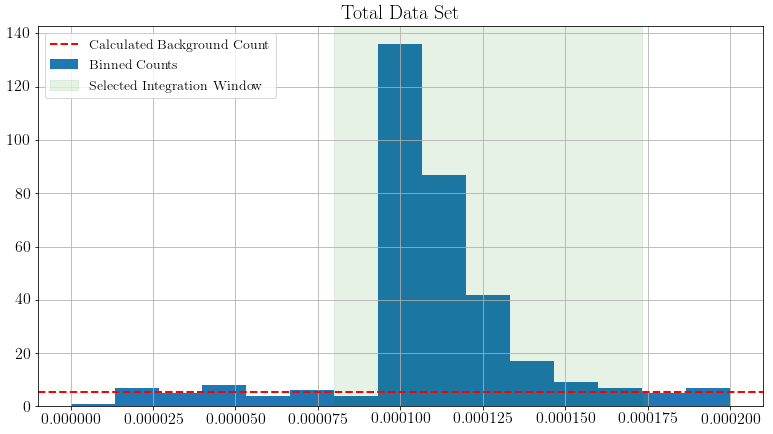

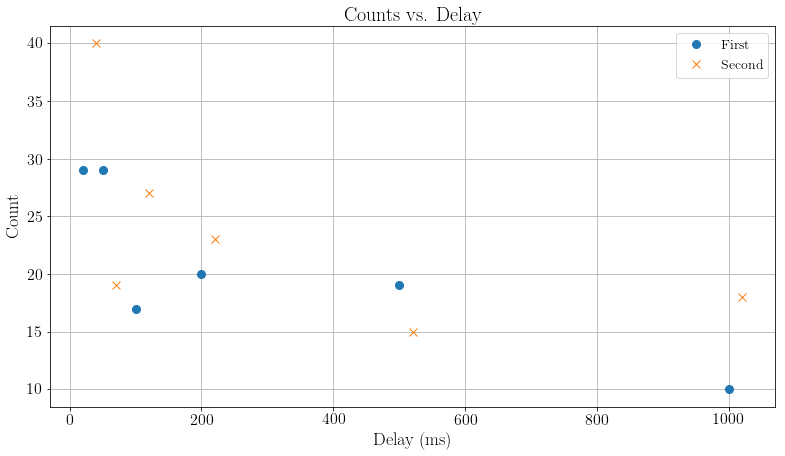

In [216]:
####### Inital params for this cell, set these before running. ####### 

# PPDS
PeakPerDataSet = False

#
BackgroundSubtract = True

#
DisplayFullOutput = False


####### Setting up the data structures we need ####### 

delays = index['delay'].unique()

# counts (ARRAY of arrays), each array will contain the times for 
# the peak region from the histogram. 
counts = [[] for i in range(len(delays))]

# ncounts (ARRAY of arrays), each array will contain the counts for 
# the peak region from the histogram. 
ncounts = [[] for i in range(len(delays))]

# CountsPerDelay (Array), each value is the sum of counts for a given delay
if PeakPerDataSet:
    CountsPerDelay = np.zeros(len(delays)) 

    
####### Binning the data, finding the integration region, and background subtraction ####### 

for i, delay in enumerate(index['delay'].unique()):
    for setindex in index[index['delay'] == delay].index:
        y = data[setindex]['ch3']
        peaks, properties = find_peaks(y, prominence=0.05, width=60, distance=30)
        counts[i] = np.concatenate((counts[i], data[setindex].iloc[peaks].index), axis=None)
    
    
    # Calculating the counts for each data set.
    if DisplayFullOutput == True:
        fig, ax = plt.subplots(figsize=(13, 7))
        ax.set_title(f'Delay: {delay}')
        ax.grid(True)
        ncounts[i], bins, _ = plt.hist(counts[i], 
                                       bins=15, 
                                       label='Binned Counts',
                                       range=(data[setindex].index.min(), 
                                                                  data[setindex].index.max()))
    else:
        ncounts[i], bins = np.histogram(counts[i], bins=15, range=(data[setindex].index.min(), 
                                                                   data[setindex].index.max()))

    # Finding the peaks on a per data set basis
    if PeakPerDataSet == True:
        # Setting the left and right limits of the peak region
        delta = bins[1] - bins[0]
        x = [bins[i+1] - delta/2 for i in range(len(bins) - 1)]

        # Finding the peak and the region around the peak
        peaks, properties = find_peaks(ncounts[i], prominence=5)
    
        # Setting the left and right limits of the peak region
        xmin = peaks[0] - 1
        xmax = properties['right_bases'][0]
        
        # Plotting results if Diaplay Full Output is on
        if DisplayFullOutput == True:
            ax.axvspan(bins[xmin], bins[xmax], color='green', alpha=0.1, 
               label="Selected Integration Window")
            
        # Calculate the background count per bin and subtract it from the bins.
        if BackgroundSubtract:
            # Integrate the area outside of the intergration window and divide by number of bins.
            background = np.sum(np.concatenate(
                (ncounts[i][:xmin], ncounts[i][xmax + 1:]), axis=None)) / (len(ncounts[i][:xmin]) + len(ncounts[i][xmax + 1:]))
            
            # Summing up counts over the integration window with background subtraction.
            CountsPerDelay[i] = np.sum(ncounts[i][xmin:xmax]) - np.round((xmax-xmin) * background)
            
            # Display the avegrage background level on the plot
            if DisplayFullOutput == True:
                ax.axhline(y=background, color='r', linestyle='--', label="Calculated Background Count")
        
        # Summing up counts over the integration window without background subtraction.
        if not BackgroundSubtract:
            CountsPerDelay[i] = np.sum(ncounts[i][xmin:xmax])
    # Plotting the region selected for integration
    ax.legend()
    plt.show()
    


####### Examing the total data set ####### 
# Insead of looking at each set of delays independently we can can examine the 
# data set as a whole. This will help provide better statistics for background
# calculations. If it's expected that data will be coming out in the same time
# window this option is ideal.

if not PeakPerDataSet:
    # Calculating the total counts from all values
    totalcount = np.concatenate(counts, axis=None)
    fig, ax = plt.subplots(figsize=(13, 7))
    
    # Creating a histogram of the total data set
    n, bins, patches = plt.hist(totalcount, 
                                bins=15, 
                                range=(data[0].index.min(), data[0].index.max()), 
                                label="Binned Counts") 
    ax.set_title('Total Data Set')
    ax.grid(True)
    
    # Generating the midpoint for each bin
    delta = bins[1] - bins[0]
    x = [bins[i+1] - delta/2 for i in range(len(bins) - 1)]
    
    ####### Plotting the total data set with peaks ####### 

    # Finding the peak and the region around the peak
    peaks, properties = find_peaks(n, prominence=10)

    # Setting the left and right limits of the peak region
    xmin = peaks[0] - 1
    xmax = properties['right_bases'][0]
    
    # Calculate the background count per bin for total data set
    # Subtract the background count from the data
    if BackgroundSubtract:
        # Integrate the area outside of the intergration window, divide by number of bins, round.
        background = np.sum(np.concatenate(
            (n[:xmin], n[xmax + 1:]), axis=None)) / (len(n[:xmin]) + len(n[xmax + 1:]))
        
        # Summing up counts over the integration window with background subtraction.
        # There is an extra factor to account for the porportion of the data to the whole data set.
        CountsPerDelay = [np.sum(ncounts[i][xmin:xmax]) - np.round((xmax-xmin) * 
                                                                   background * 
                                                                   np.sum(index['delay'] == delays[i]) / 
                                                                   len(index)) for i in range(len(ncounts))]
        
        # Display the avegrage background level on the plot
        ax.axhline(y=background, color='r', linestyle='--', label="Calculated Background Count")
    
    # Summing up counts over the integration window without background subtraction.
    if not BackgroundSubtract:
        CountsPerDelay = [np.sum(ncounts[i][xmin:xmax]) for i in range(len(ncounts))]
        
    
    # Plotting the region selected for integration
    ax.axvspan(bins[xmin], bins[xmax], color='green', alpha=0.1, 
               label="Selected Integration Window")
    ax.legend()
    plt.show()

    
# Plot the final Count vs. Delay plot
fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(index['delay'].unique()[0:6], CountsPerDelay[0:6], 'o', label='First')
ax.plot(index['delay'].unique()[6:], CountsPerDelay[6:], 'x', label='Second')
ax.set_xlabel('Delay (ms)')
ax.set_ylabel('Count')
ax.set_title('Counts vs. Delay') 
ax.legend()
ax.grid(True)

plt.show()

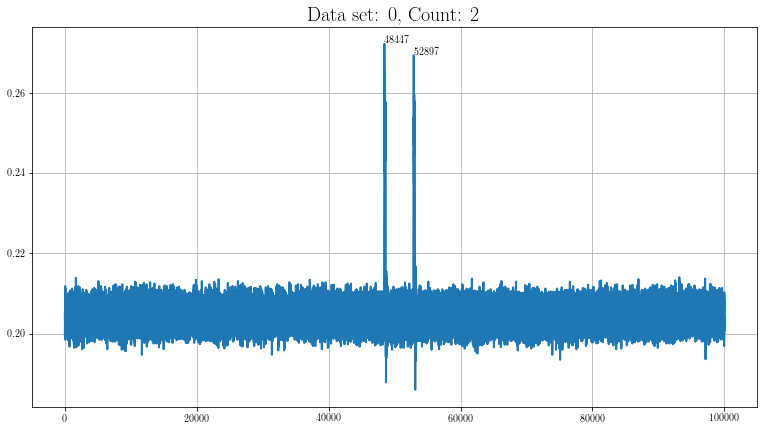

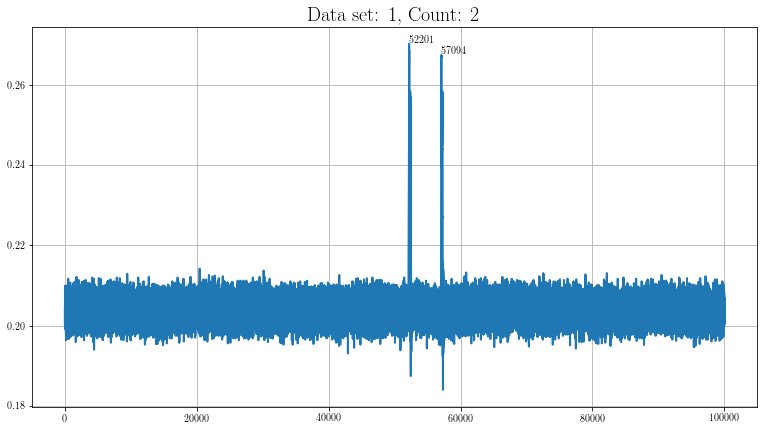

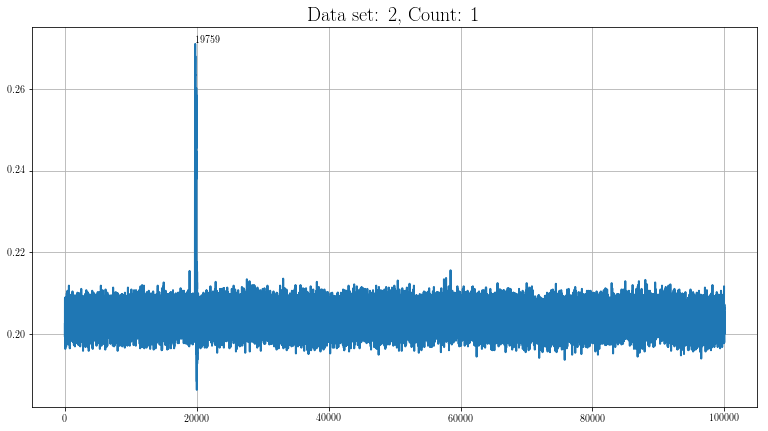

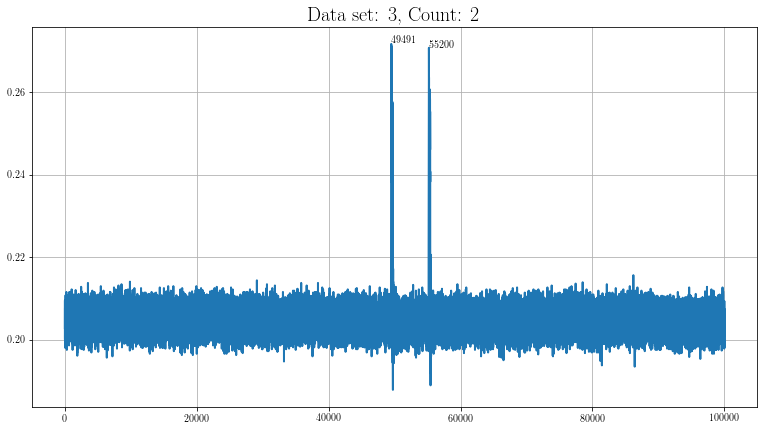

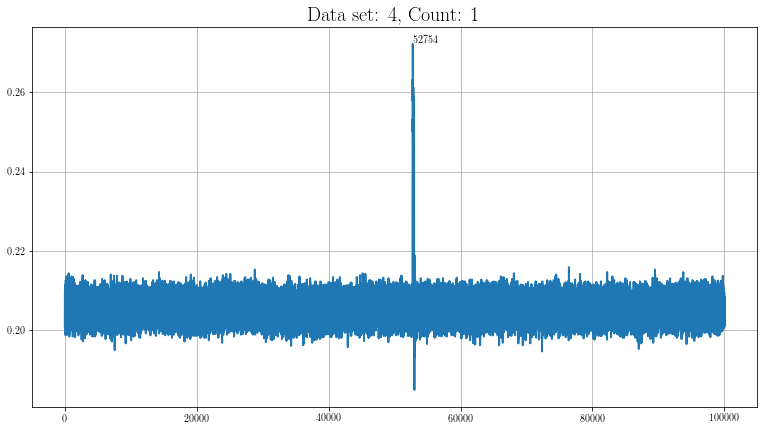

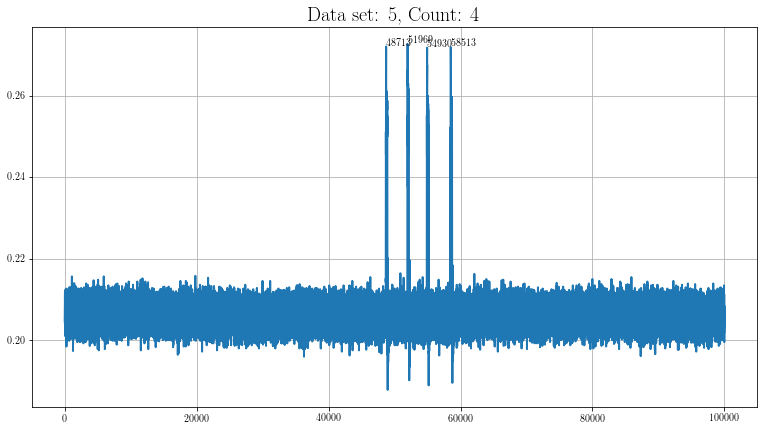

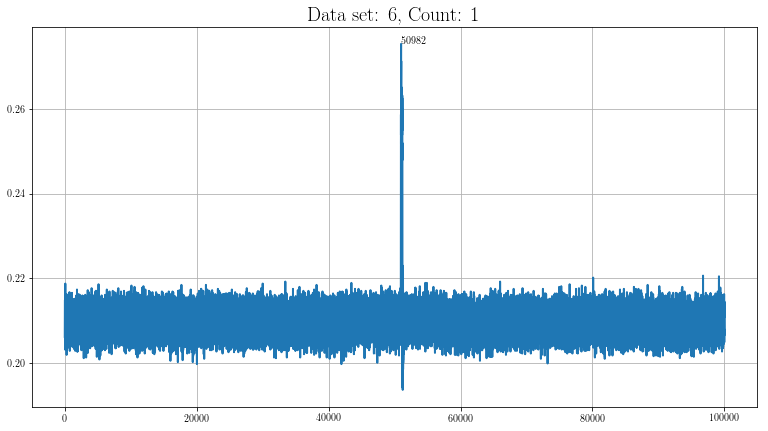

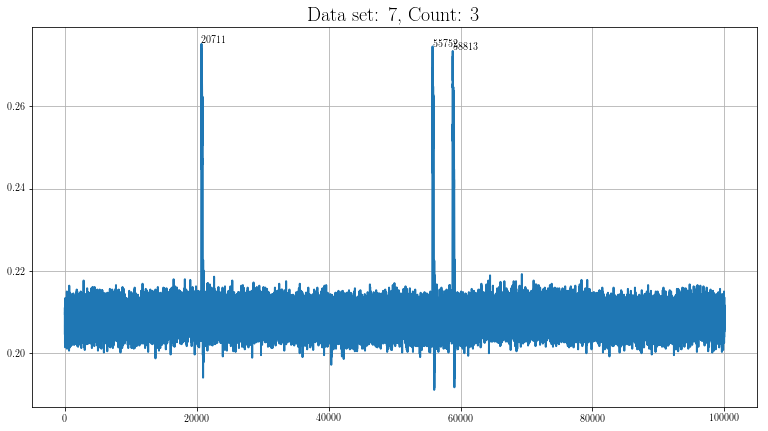

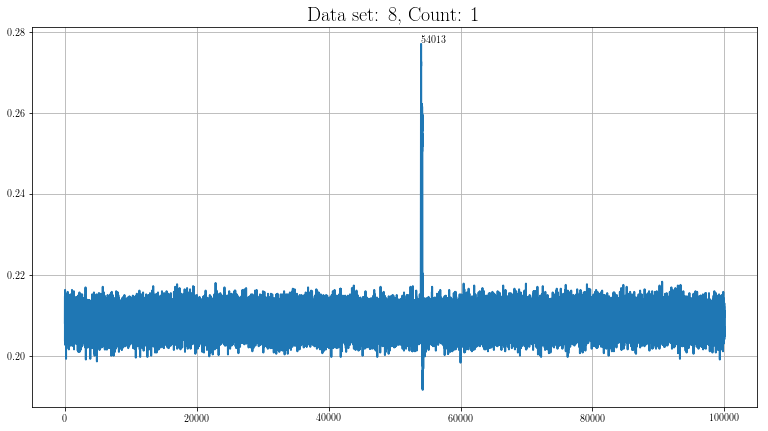

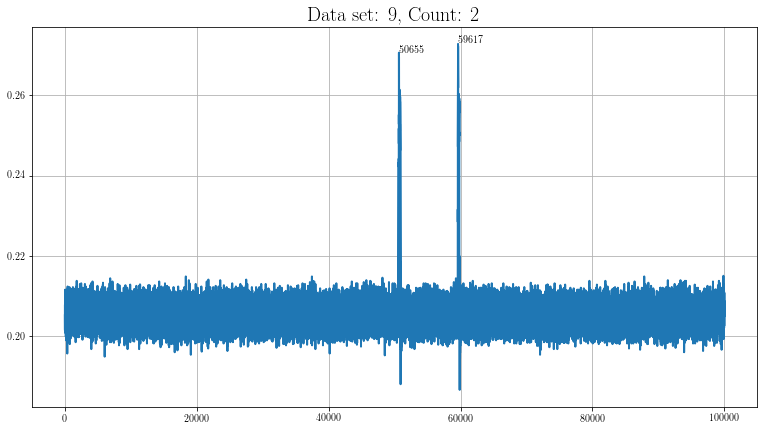

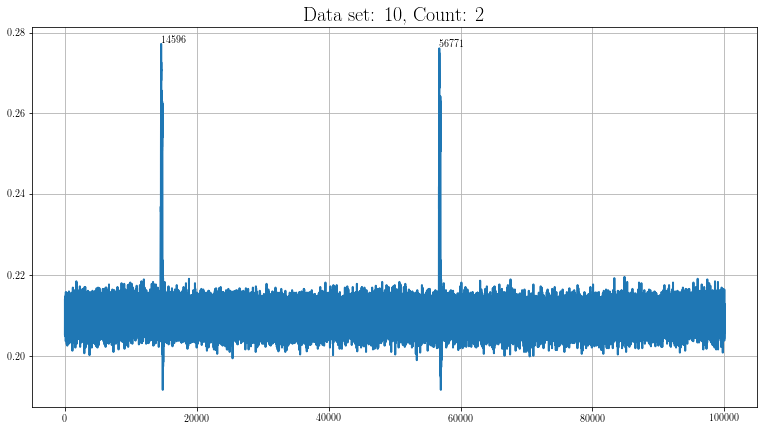

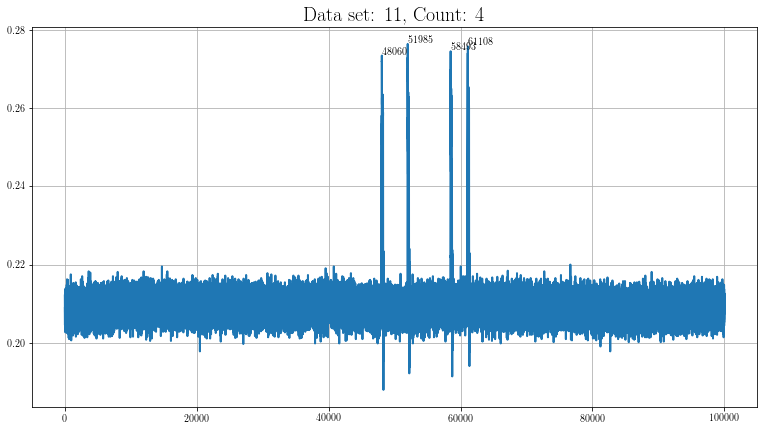

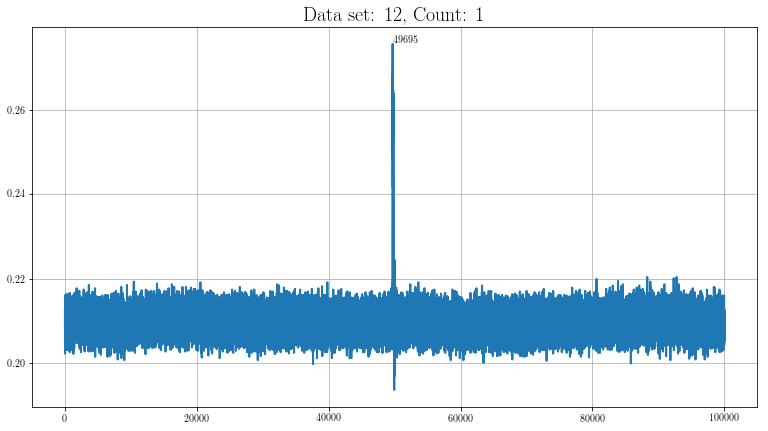

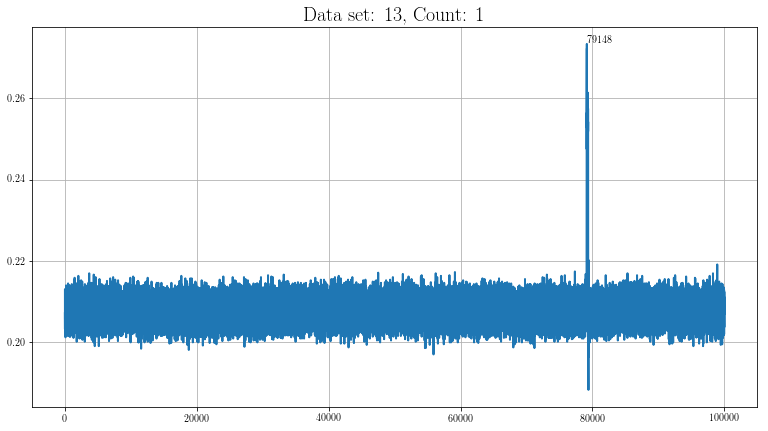

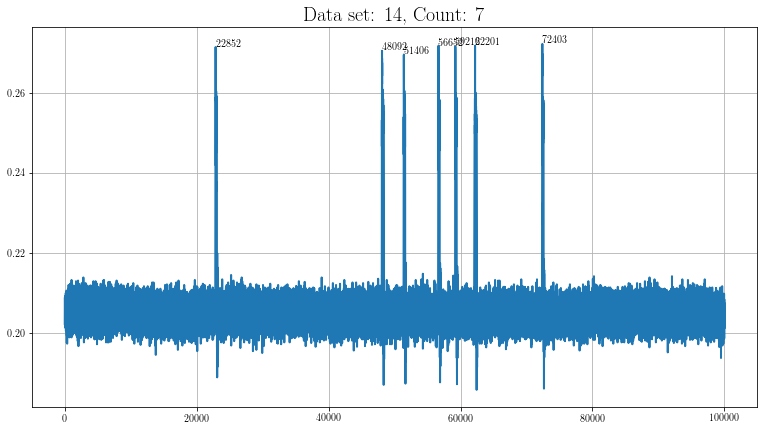

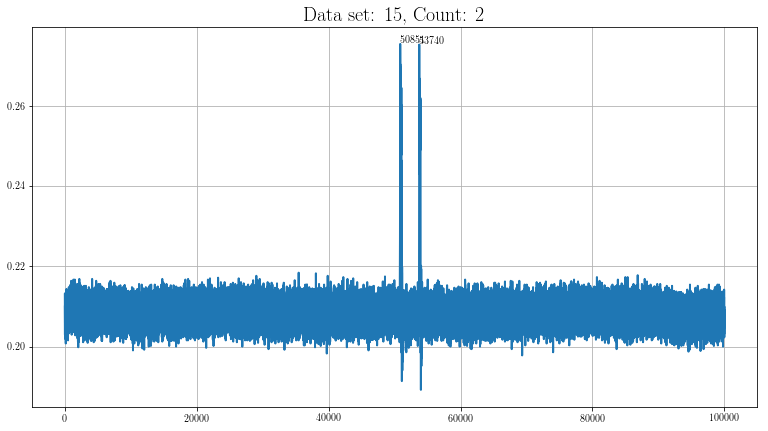

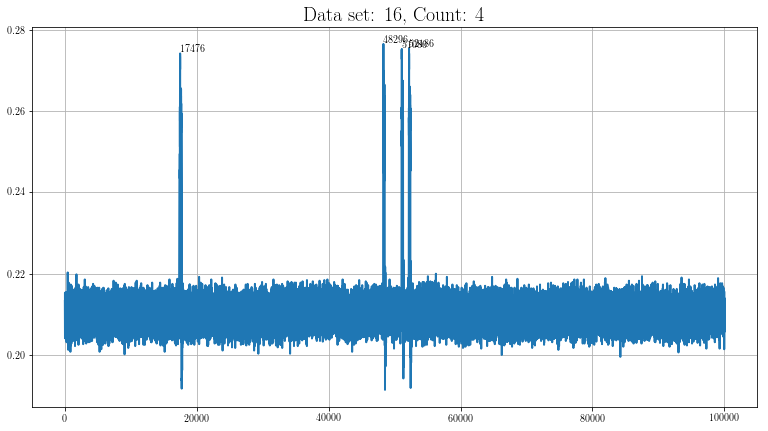

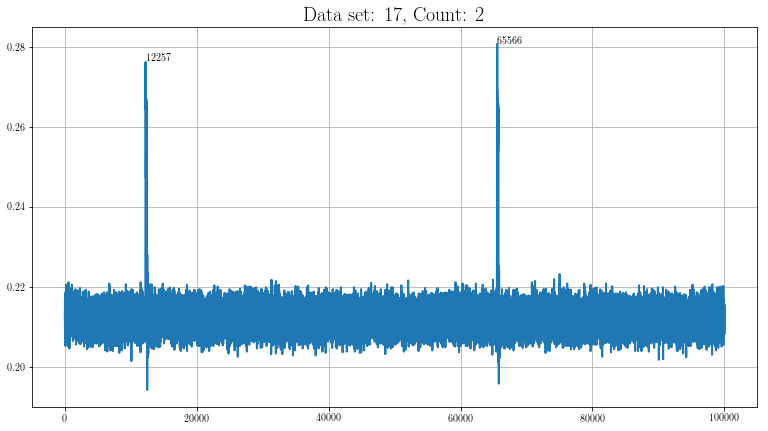

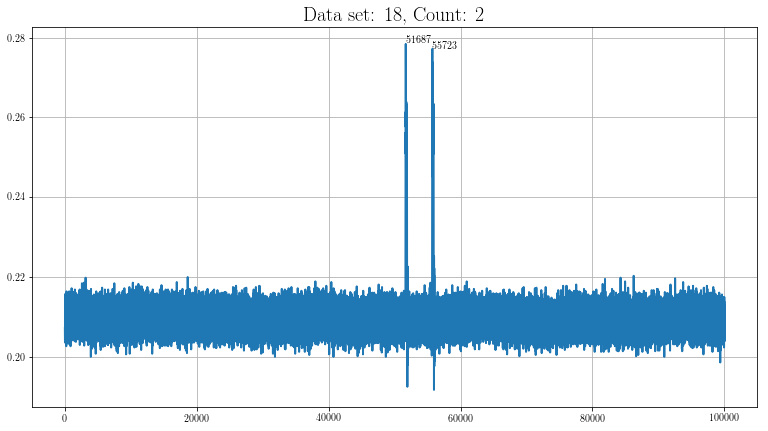

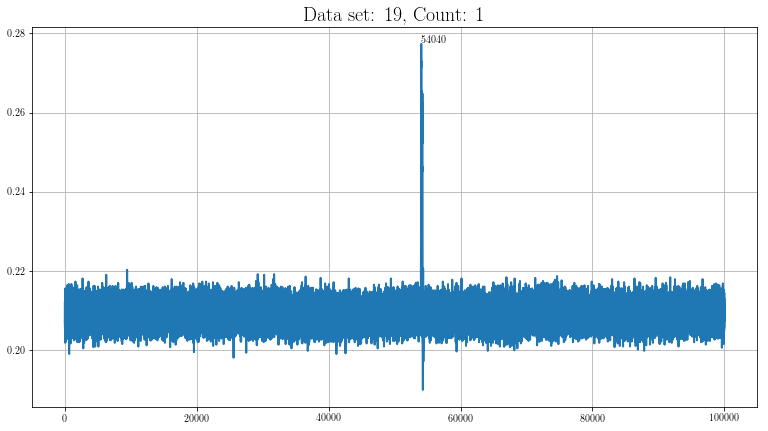

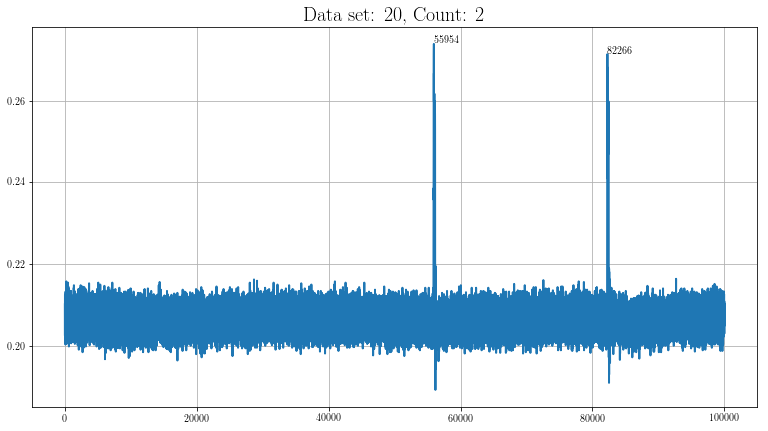

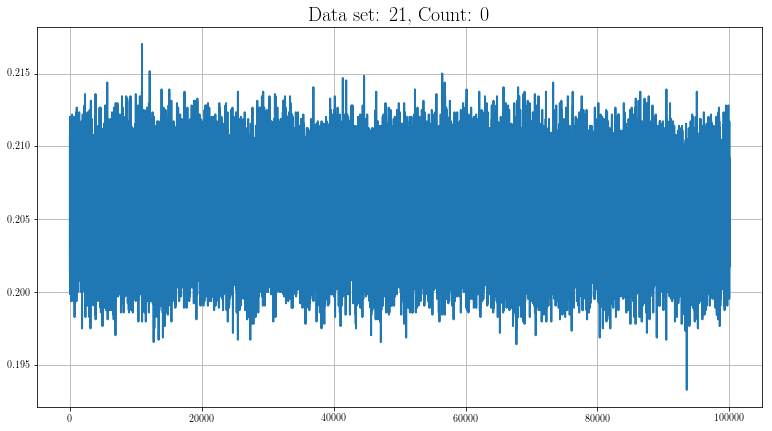

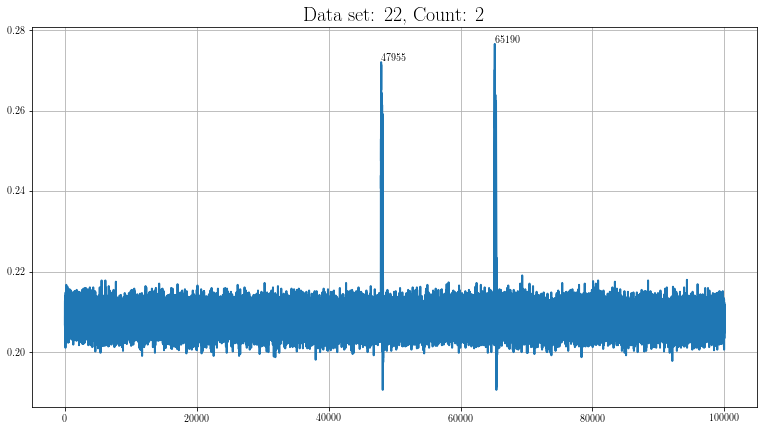

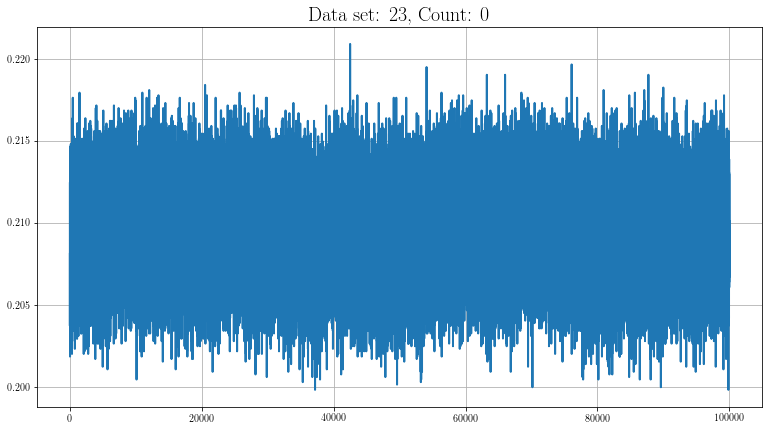

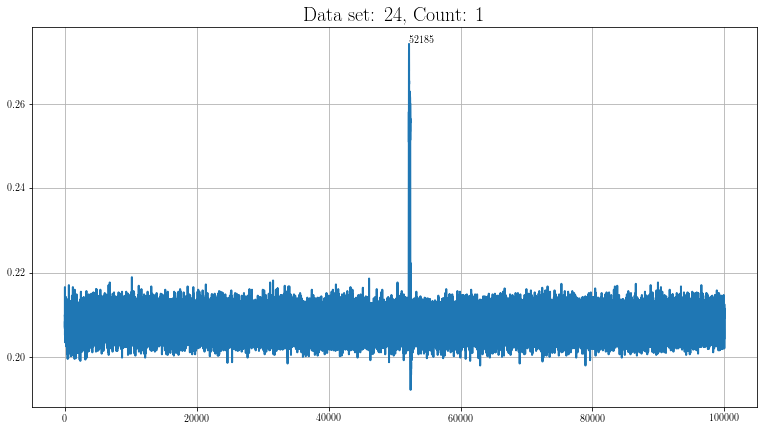

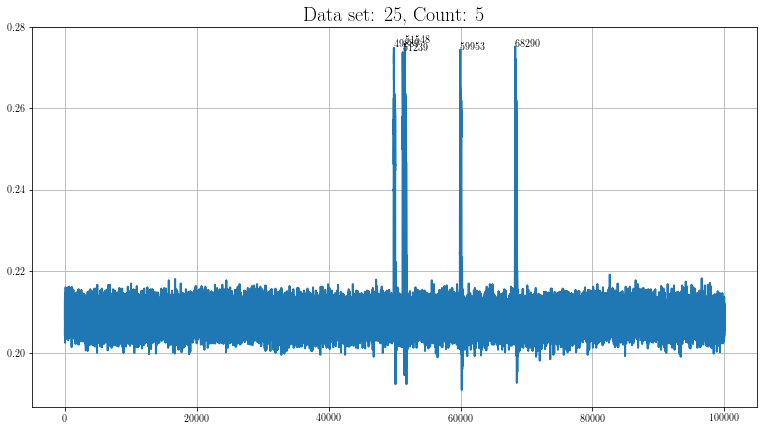

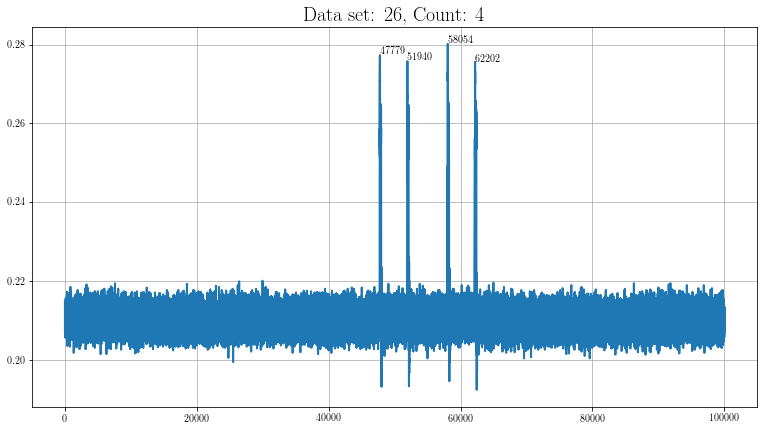

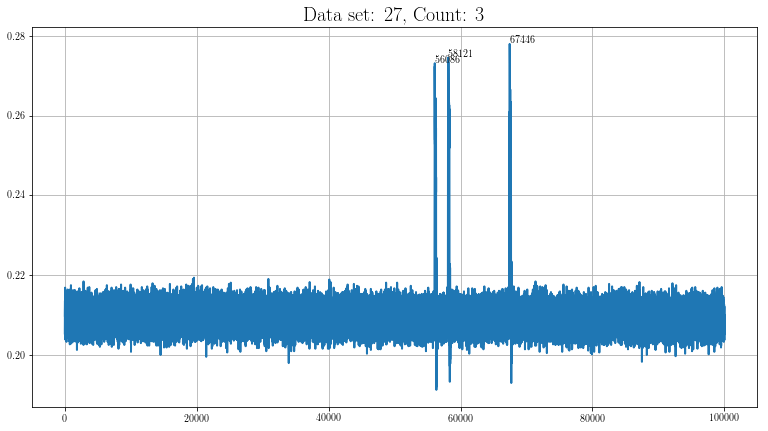

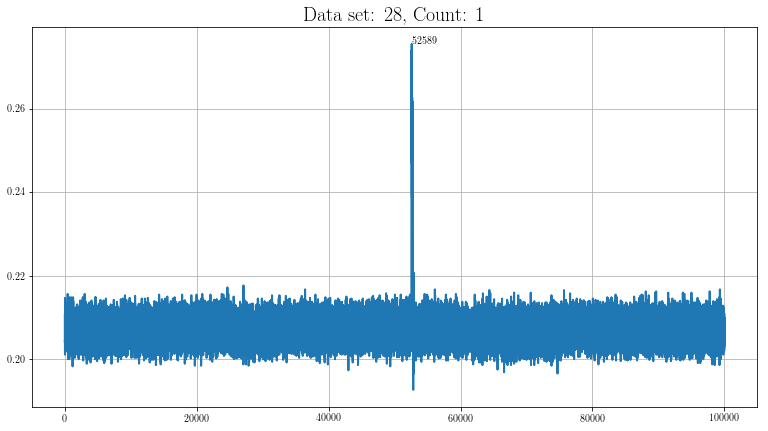

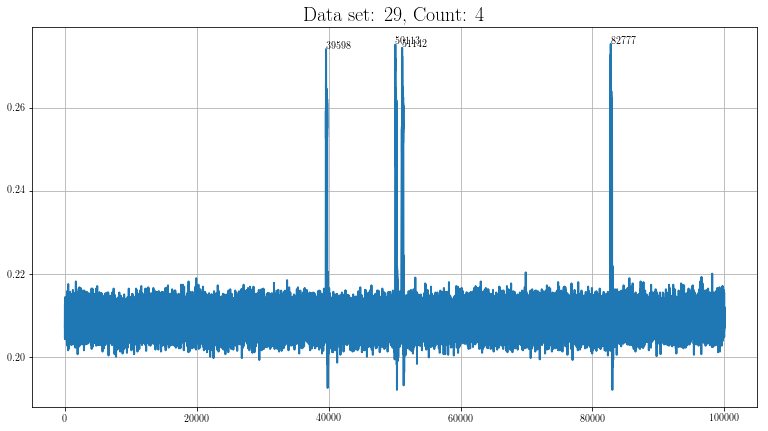

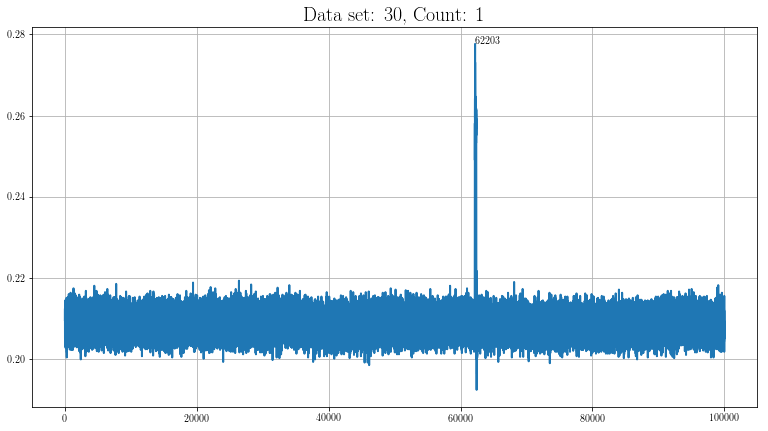

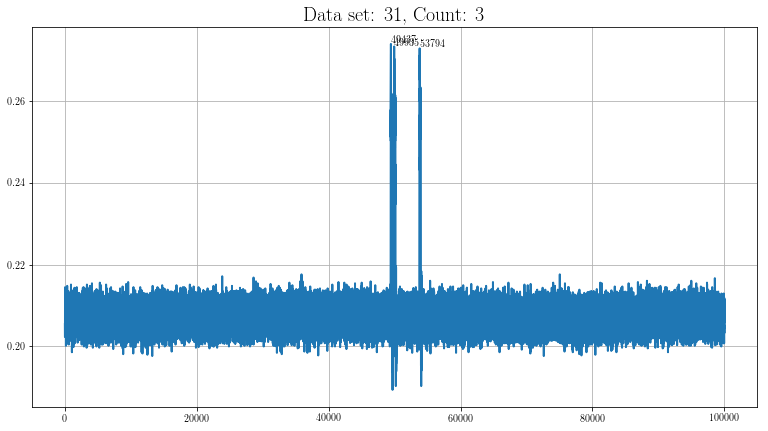

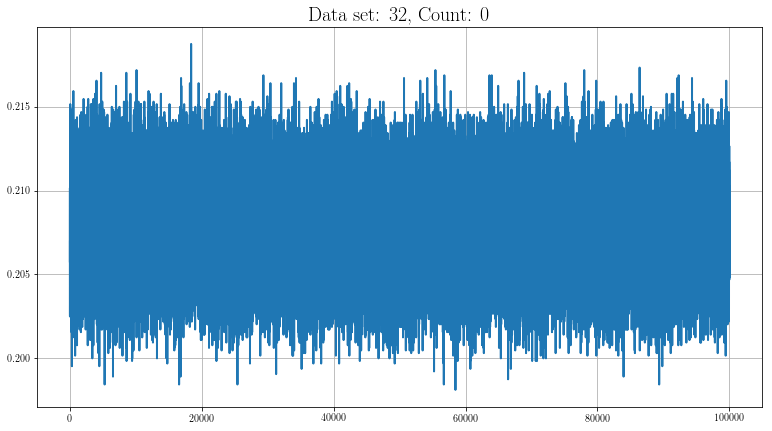

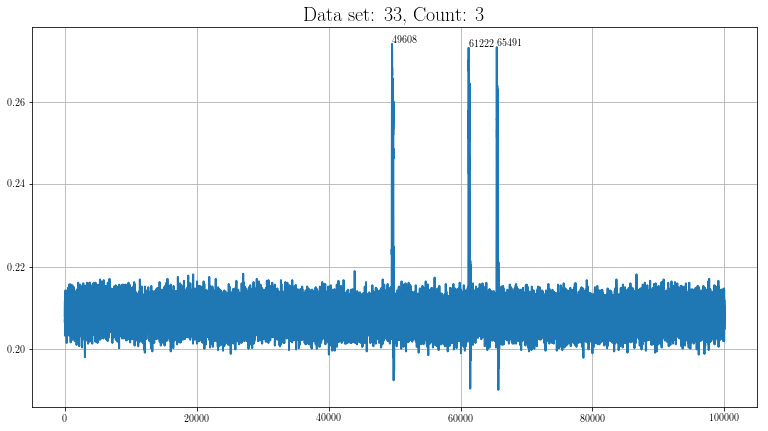

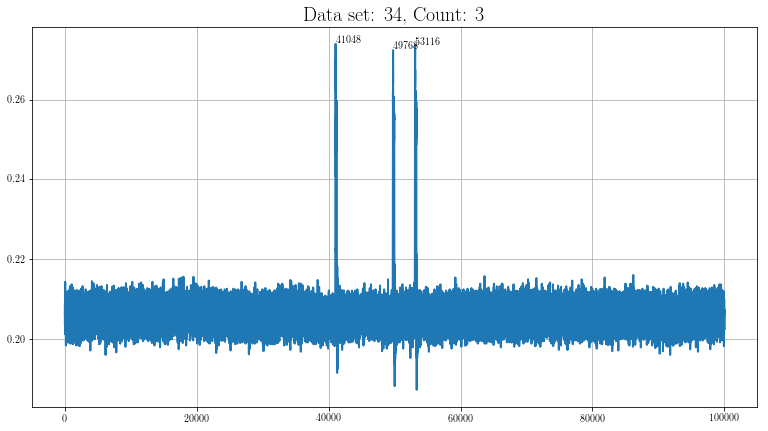

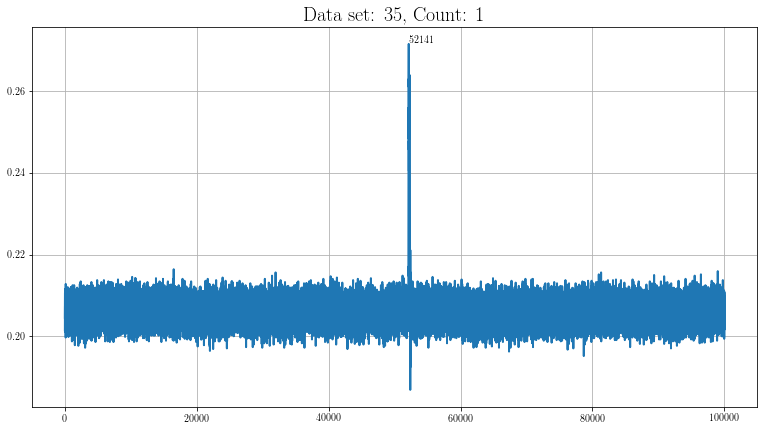

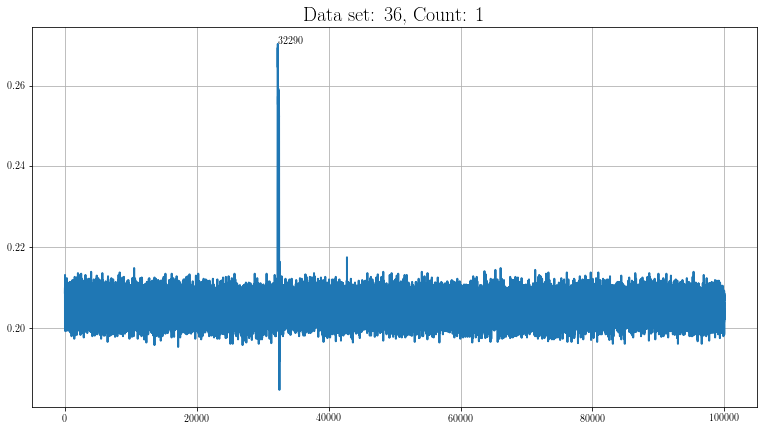

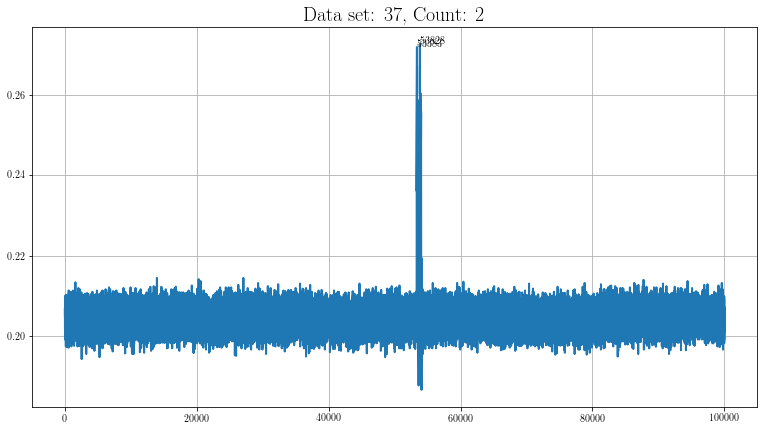

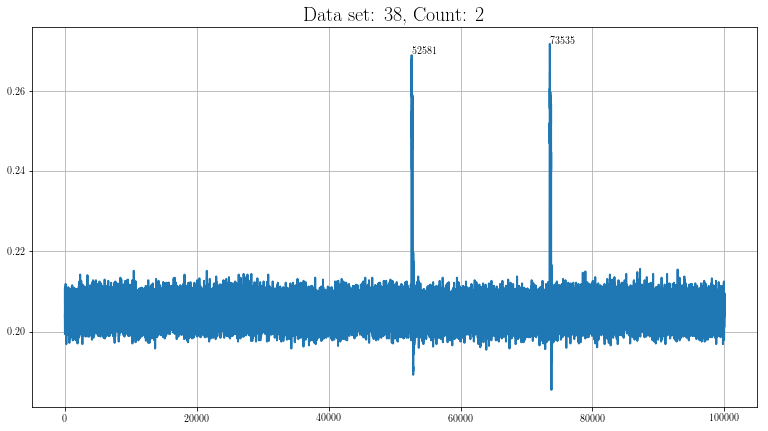

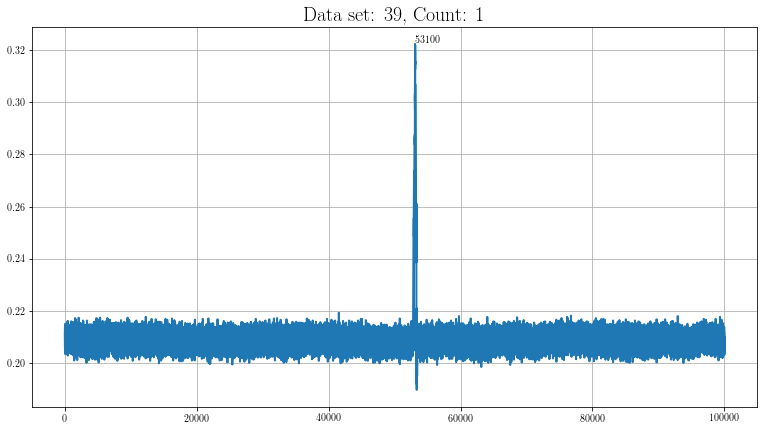

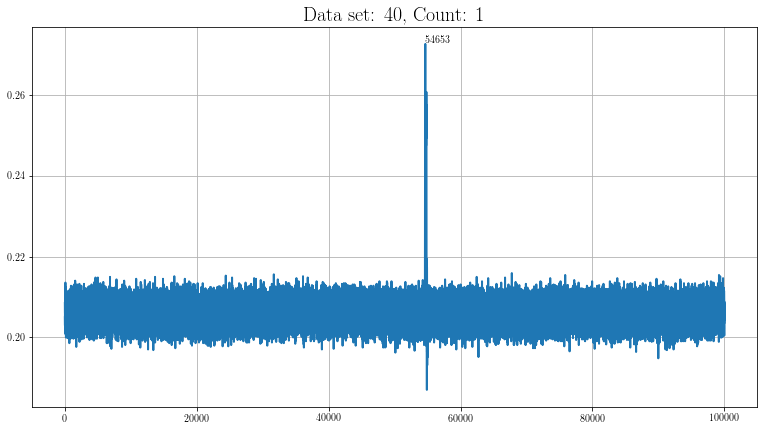

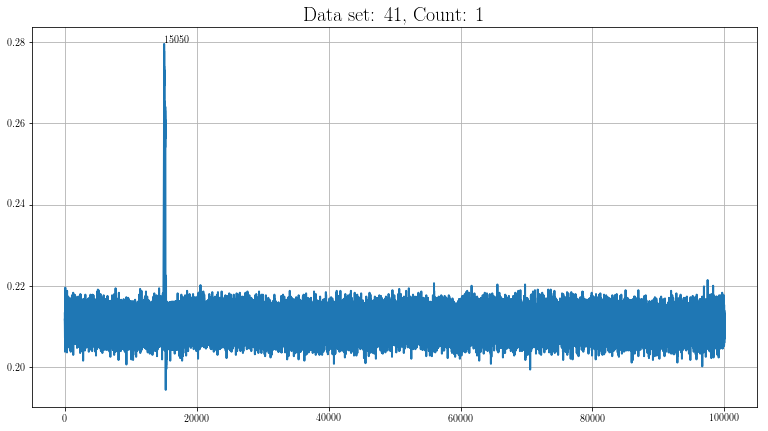

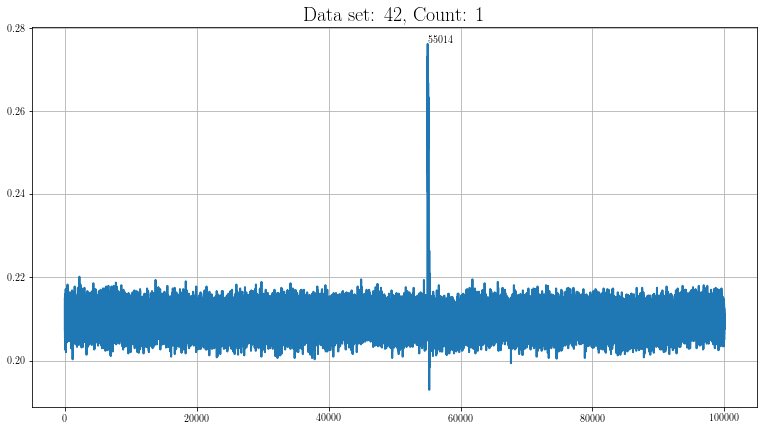

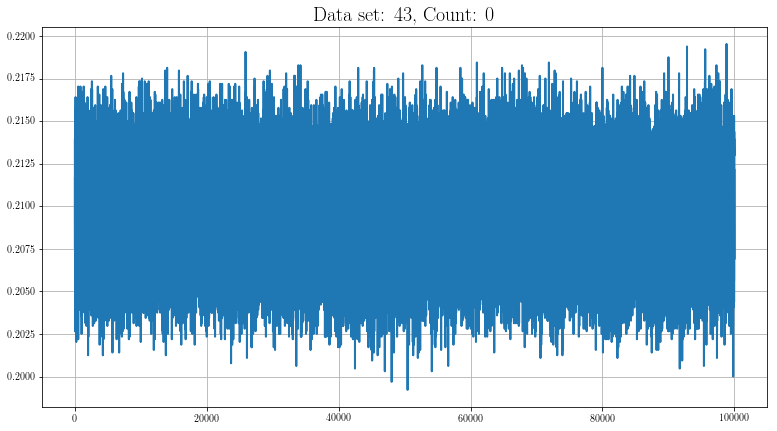

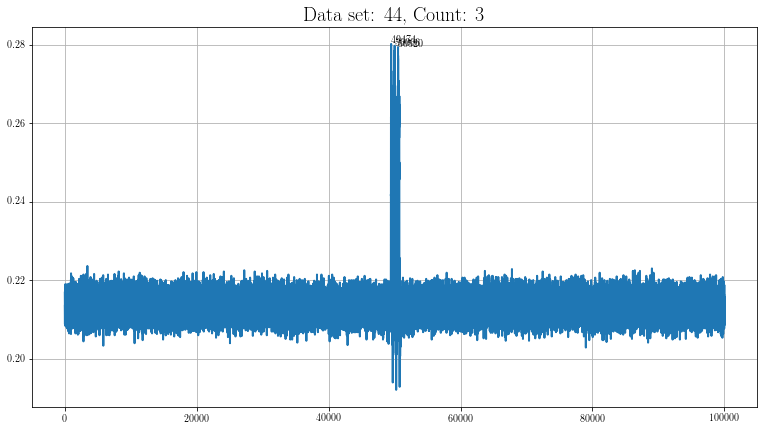

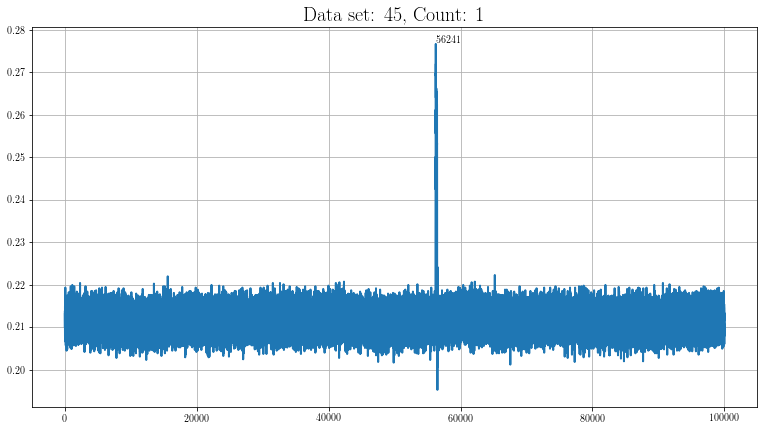

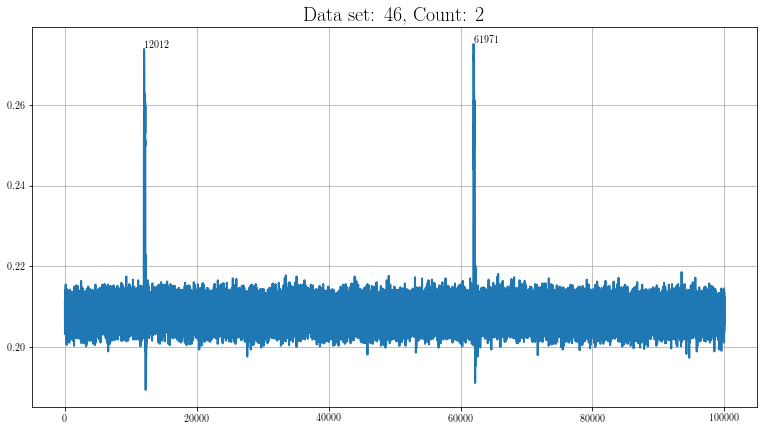

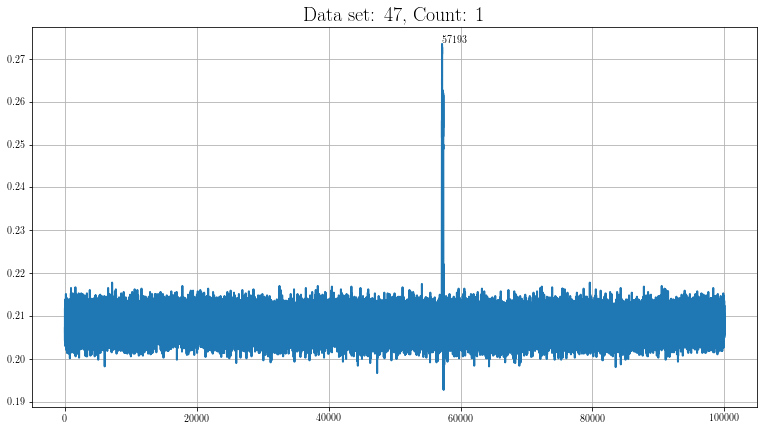

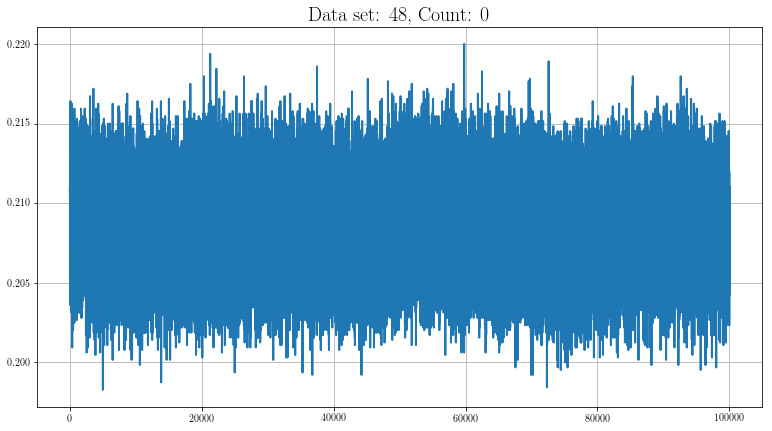

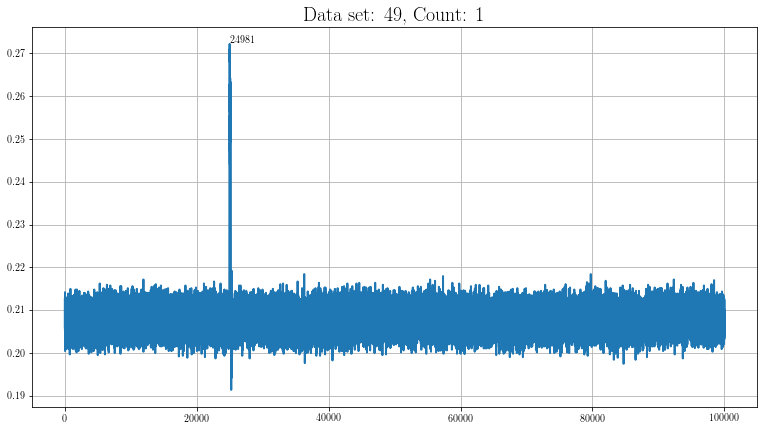

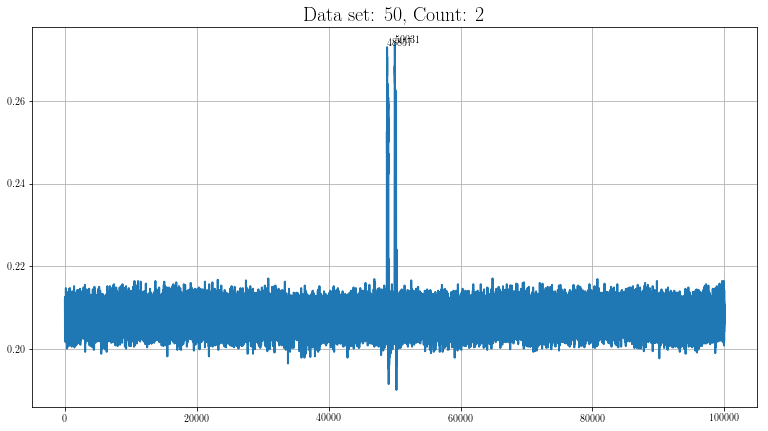

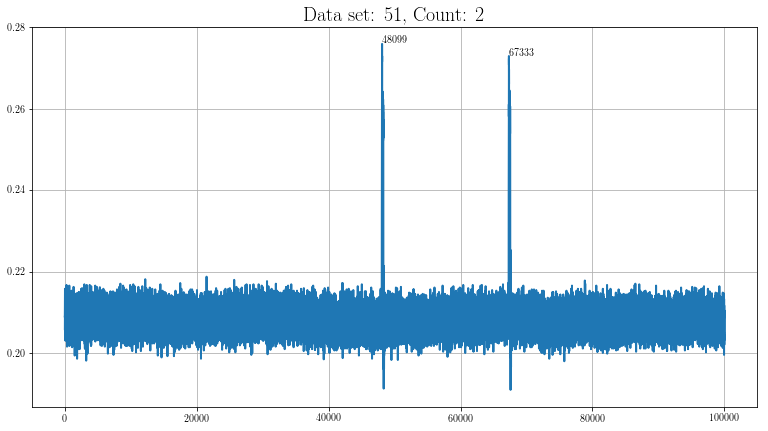

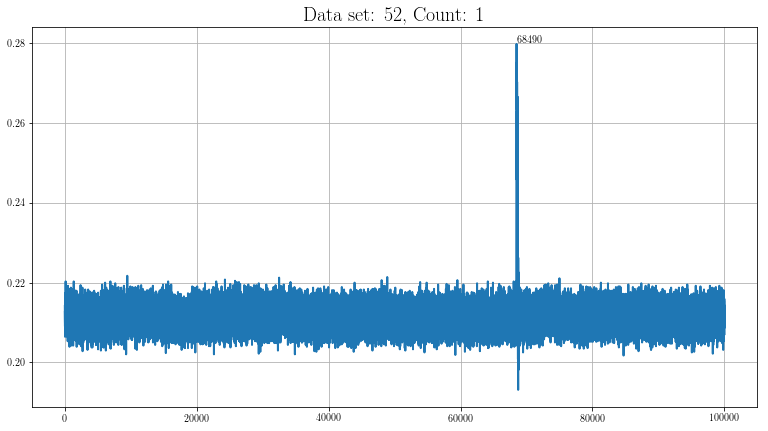

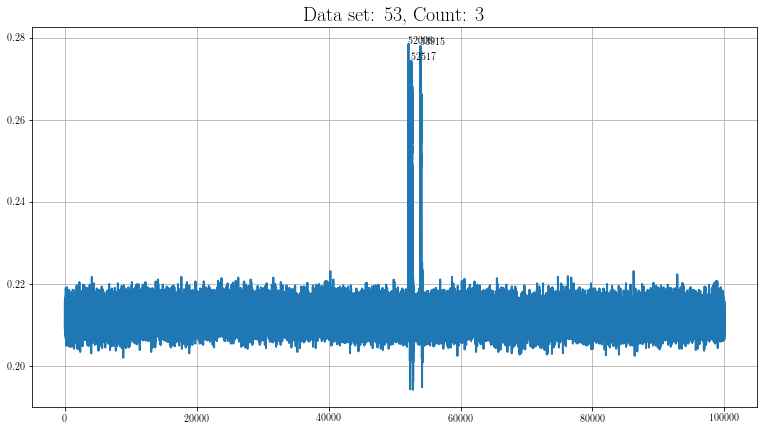

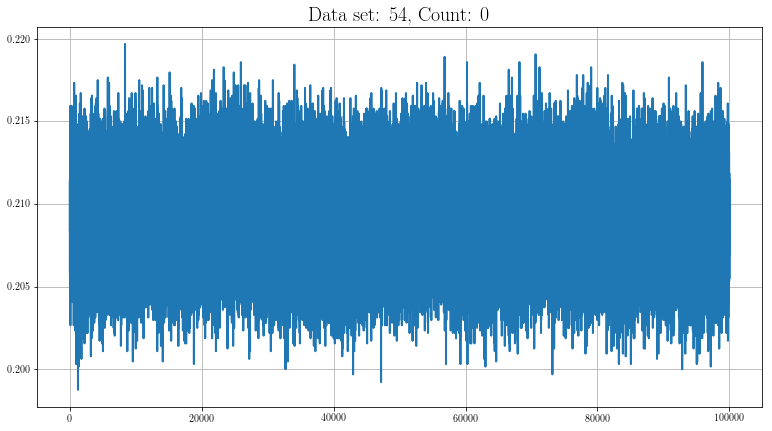

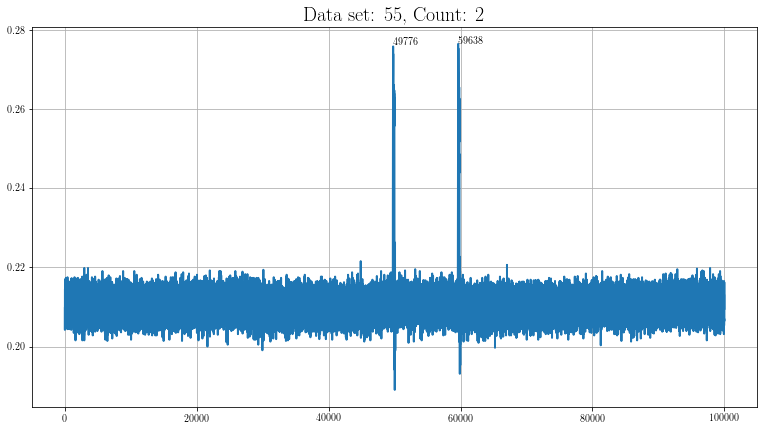

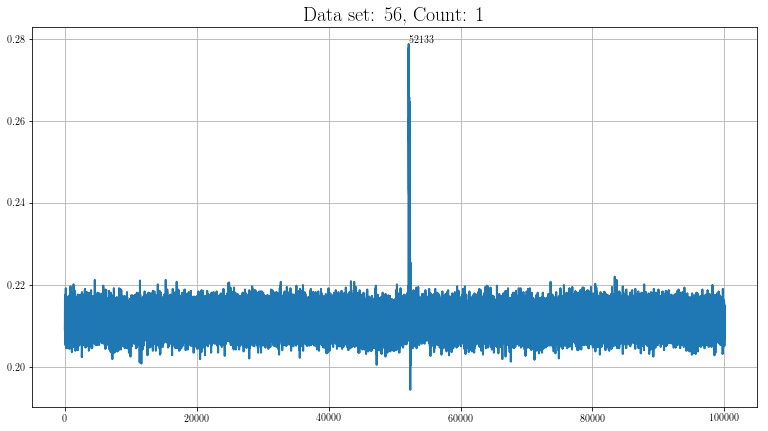

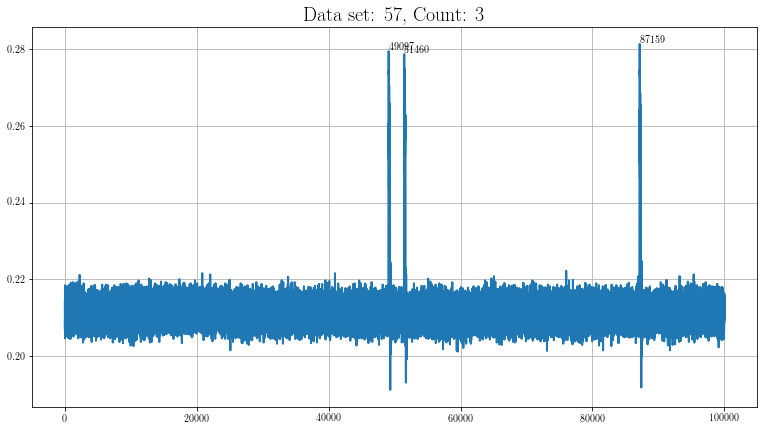

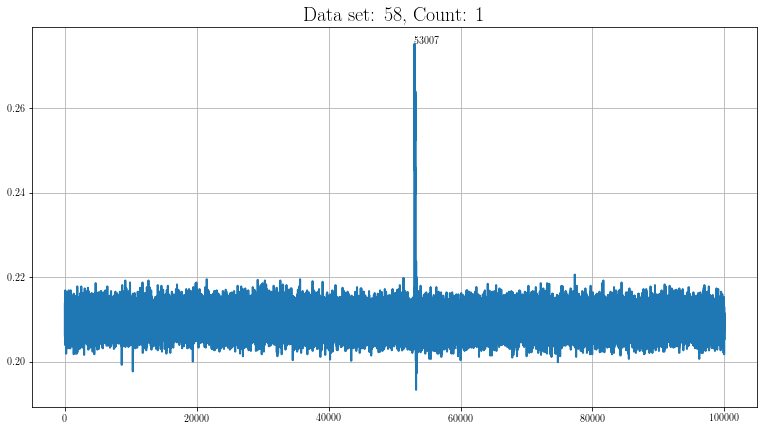

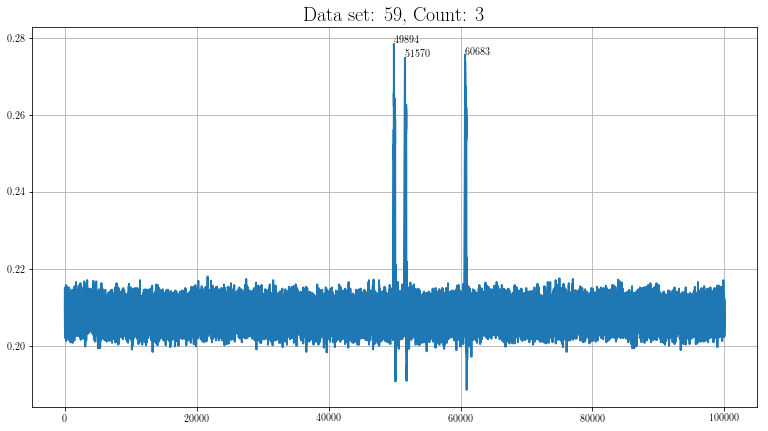

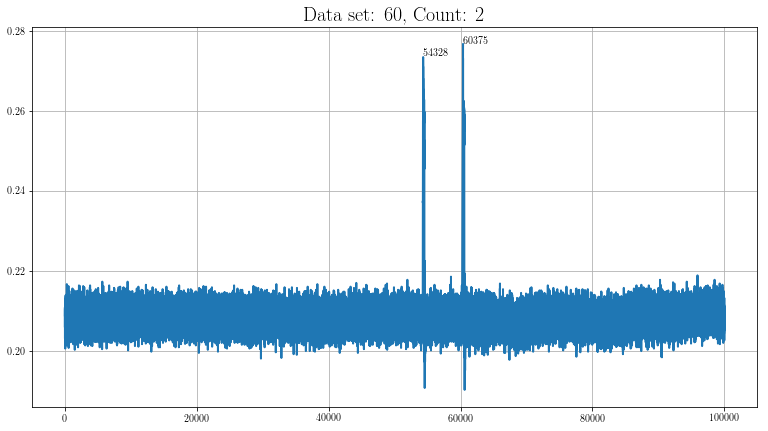

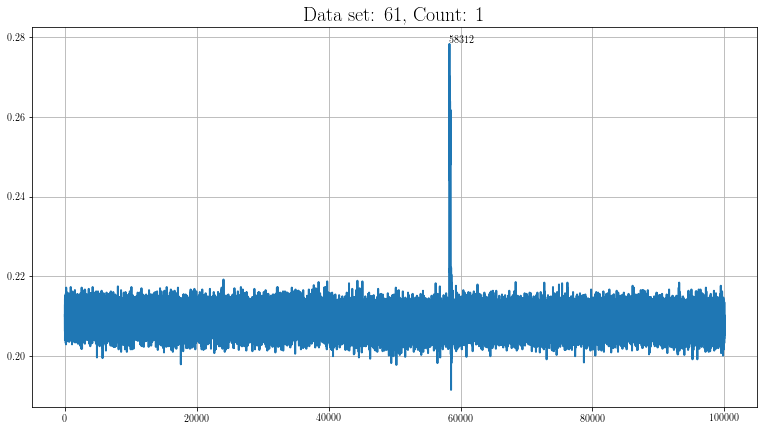

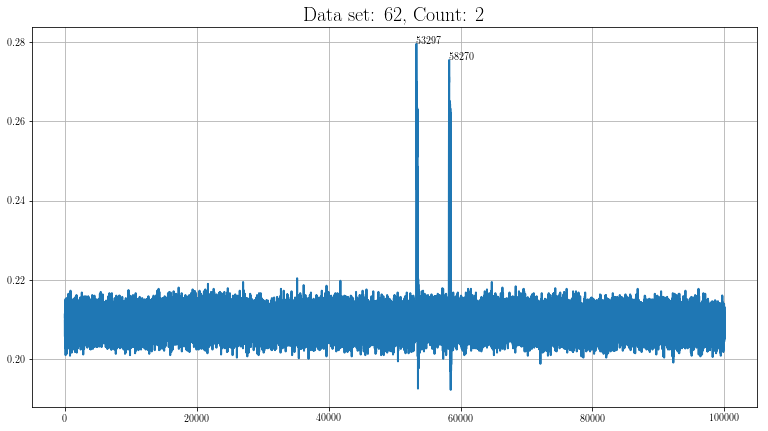

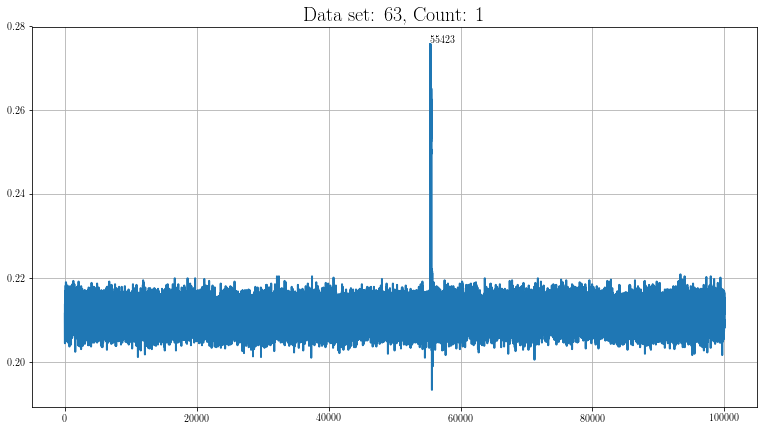

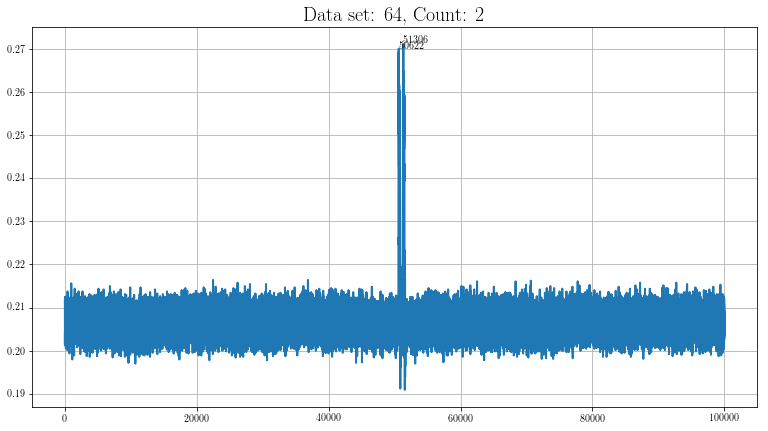

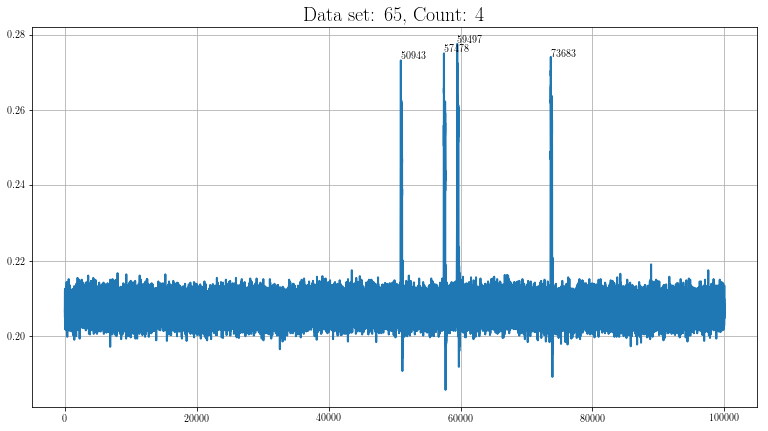

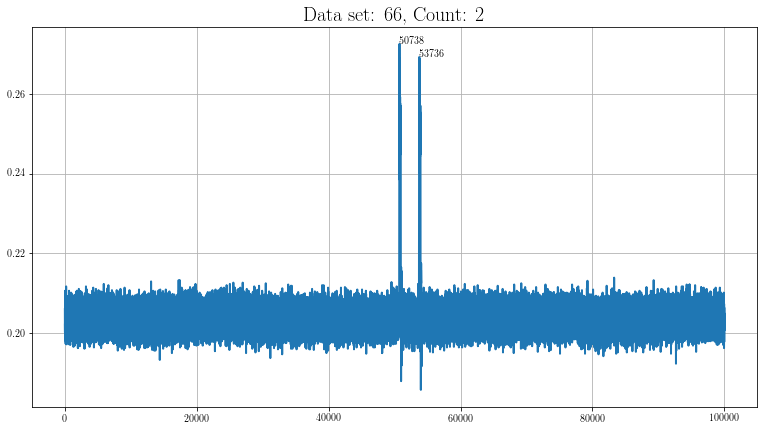

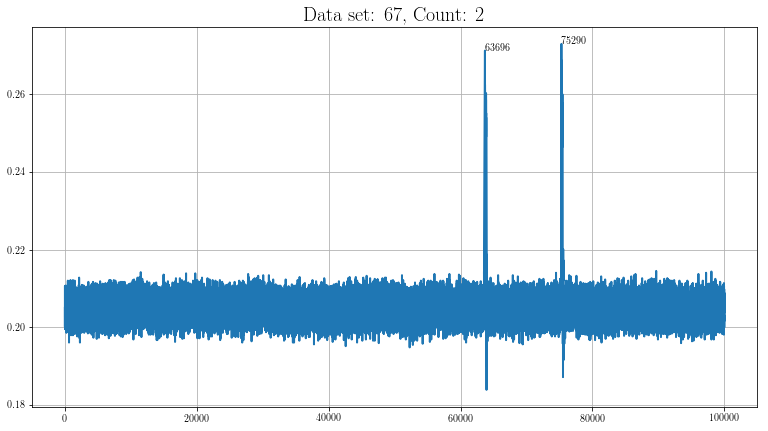

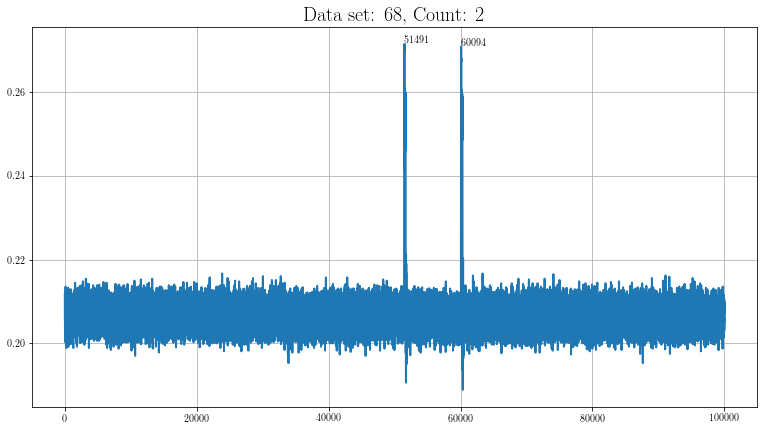

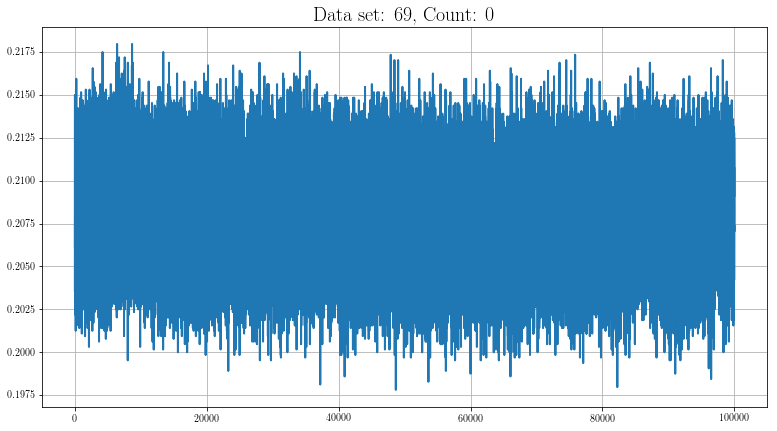

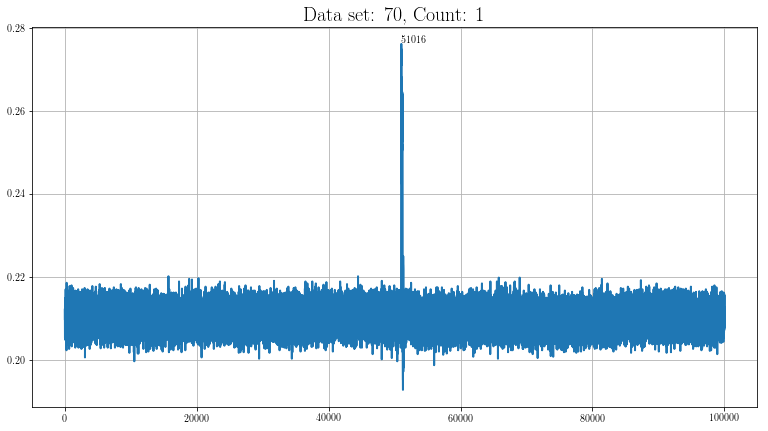

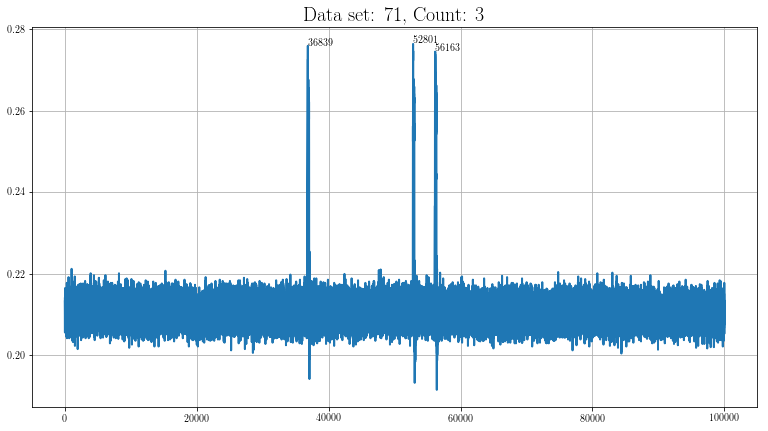

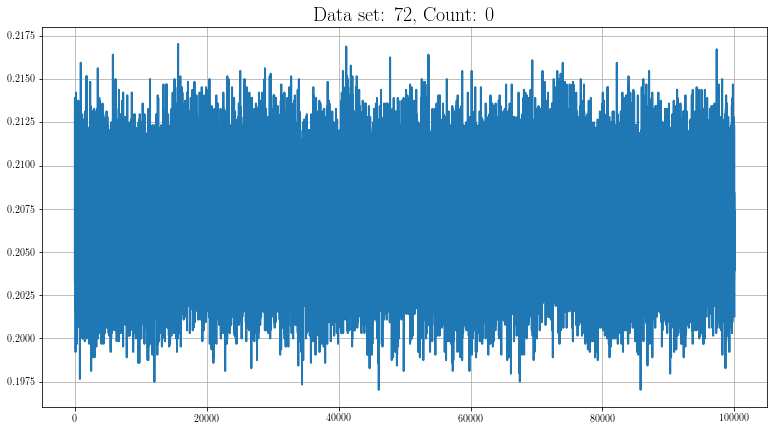

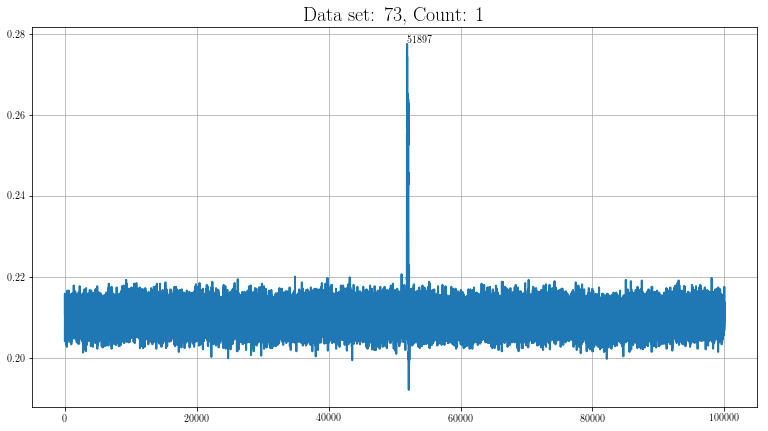

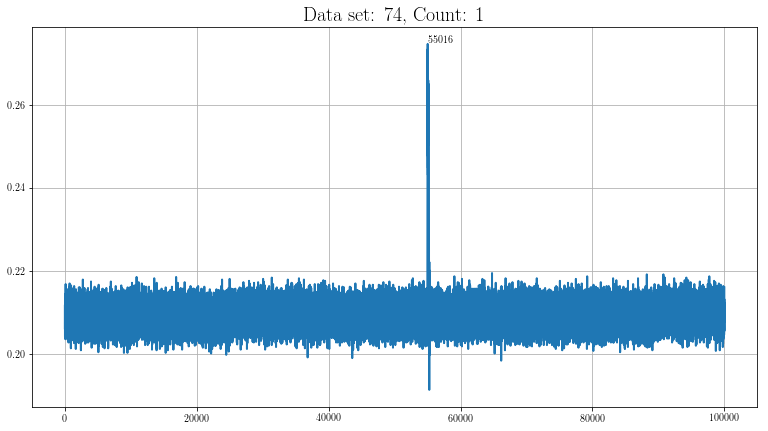

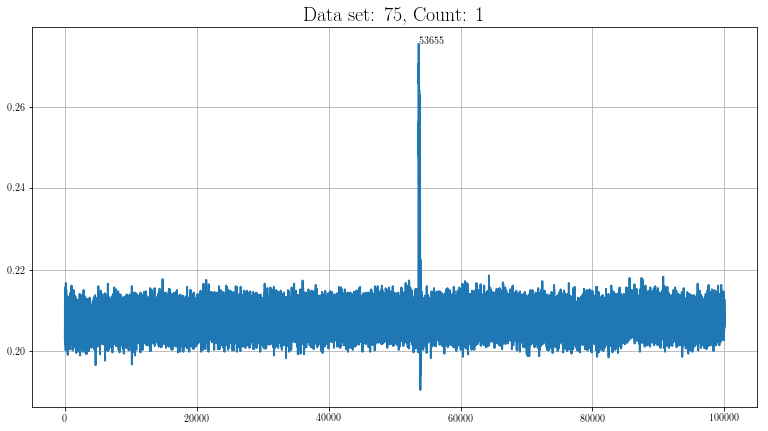

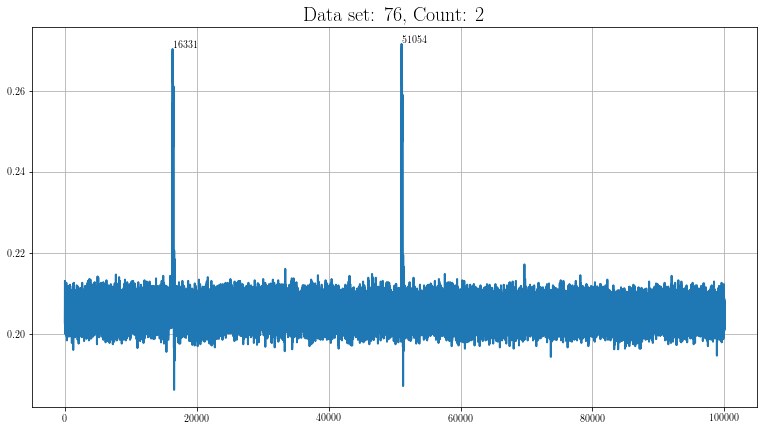

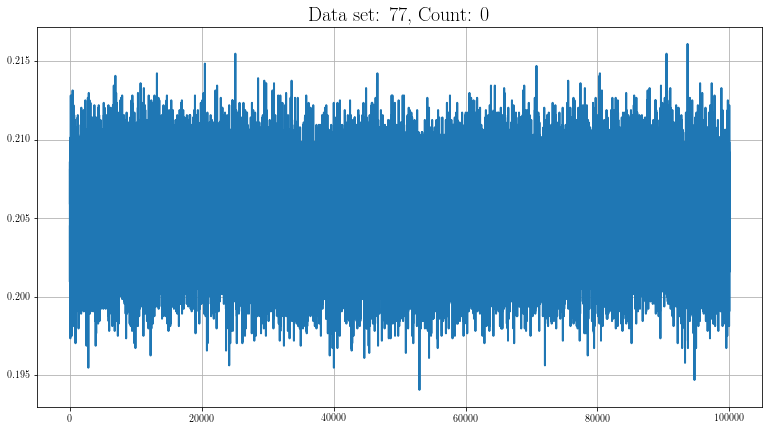

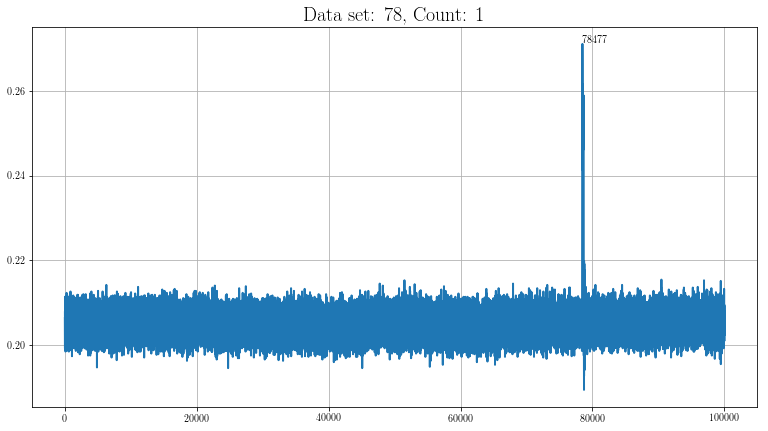

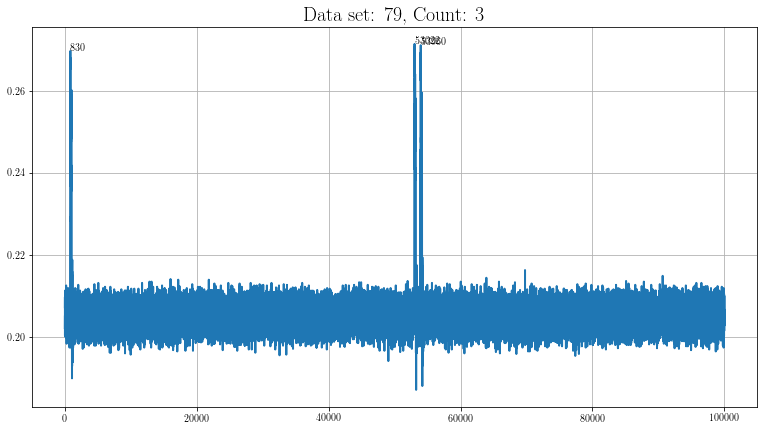

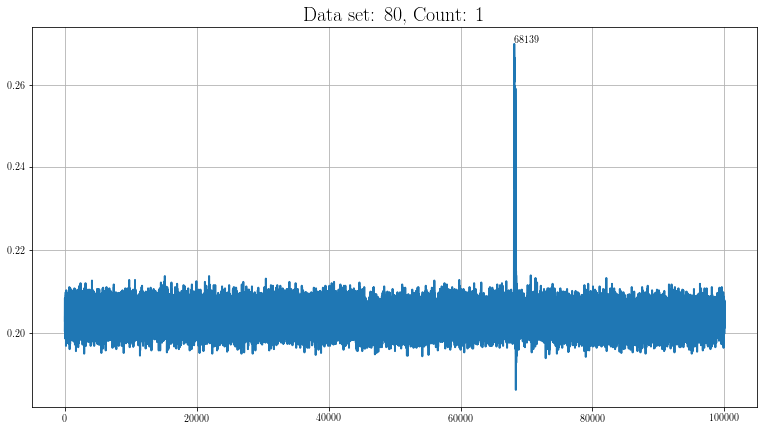

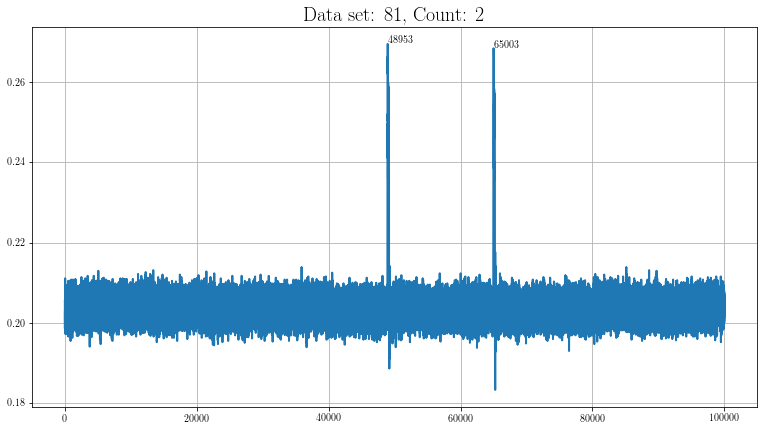

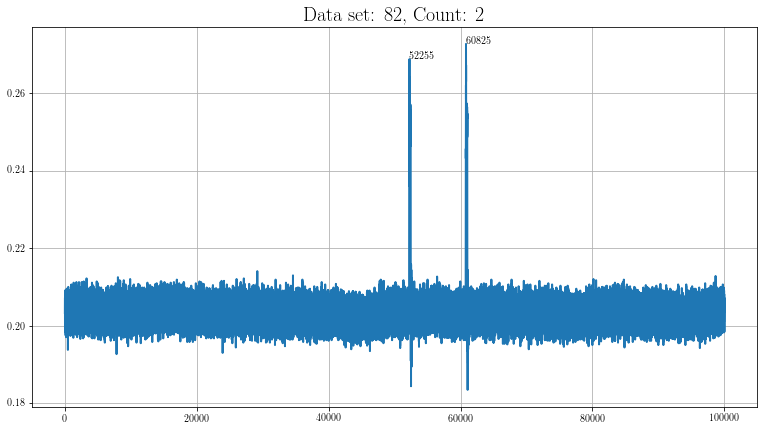

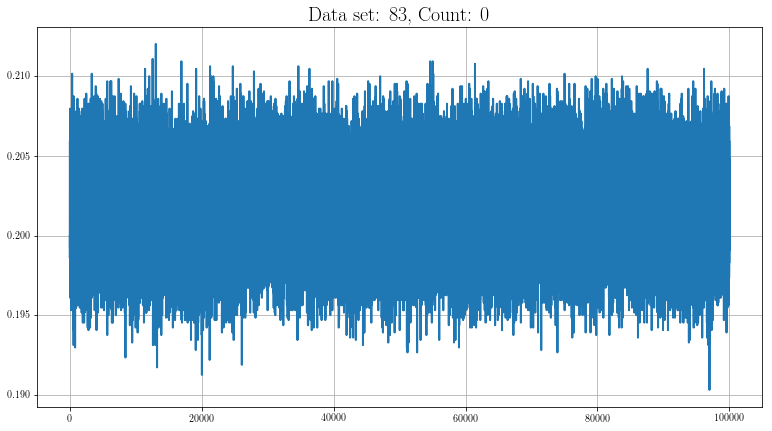

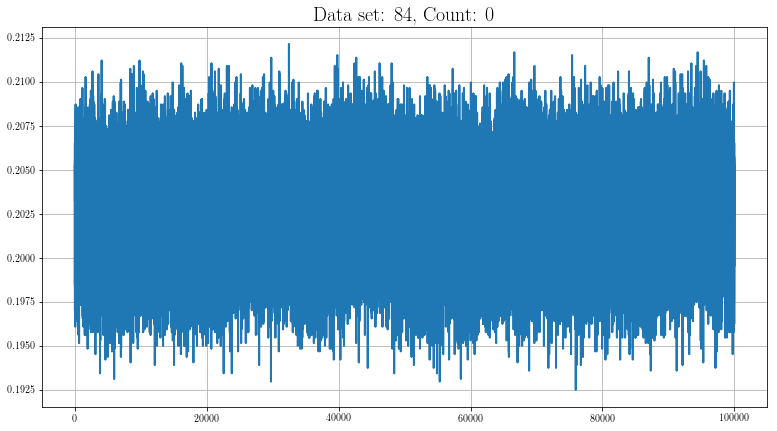

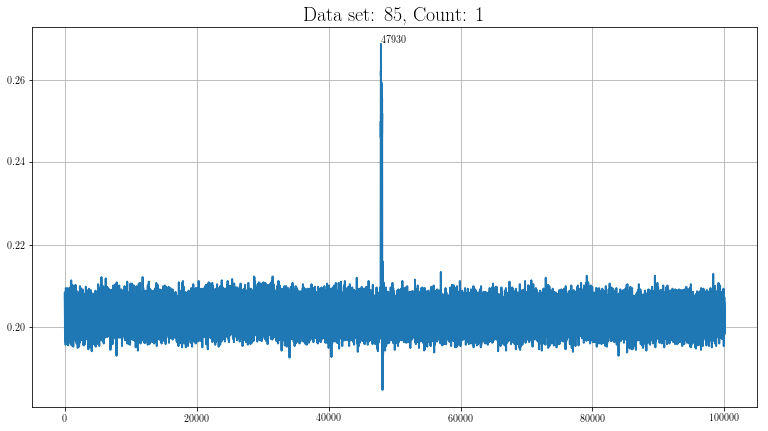

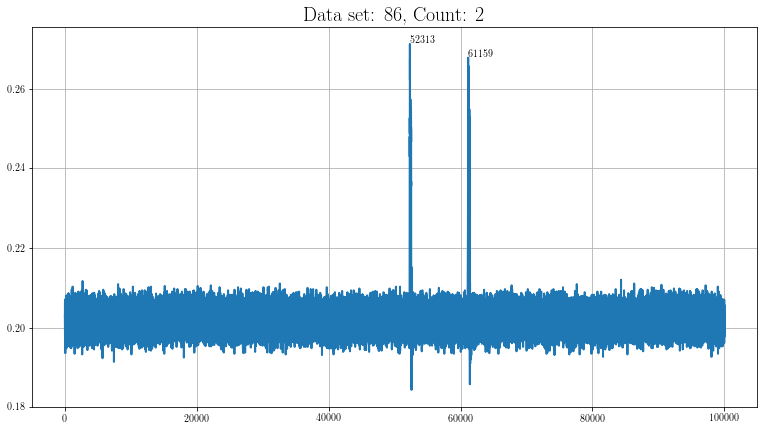

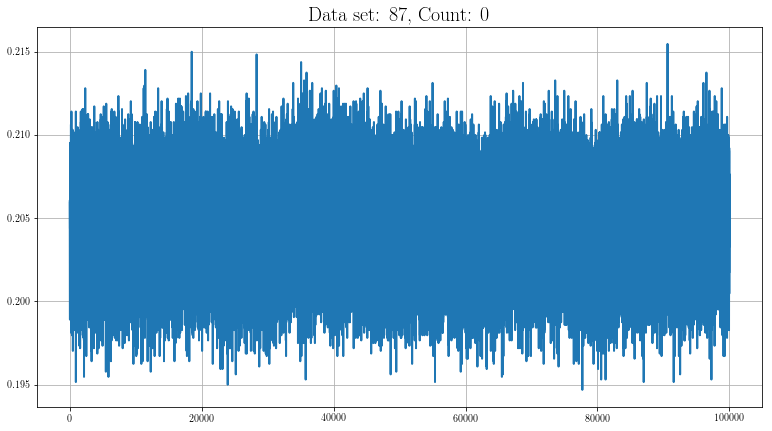

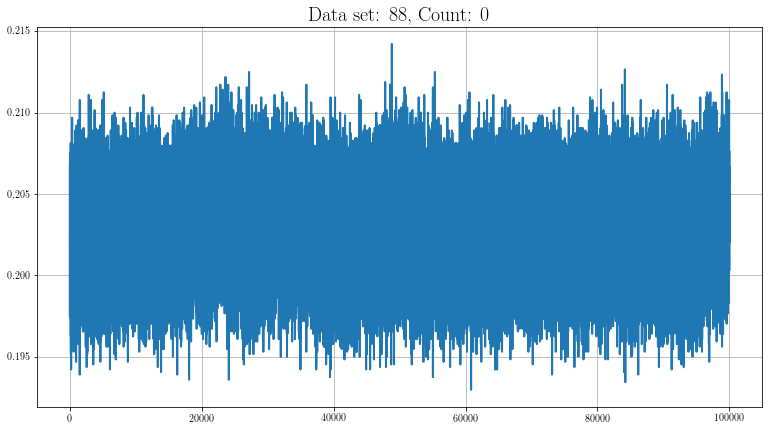

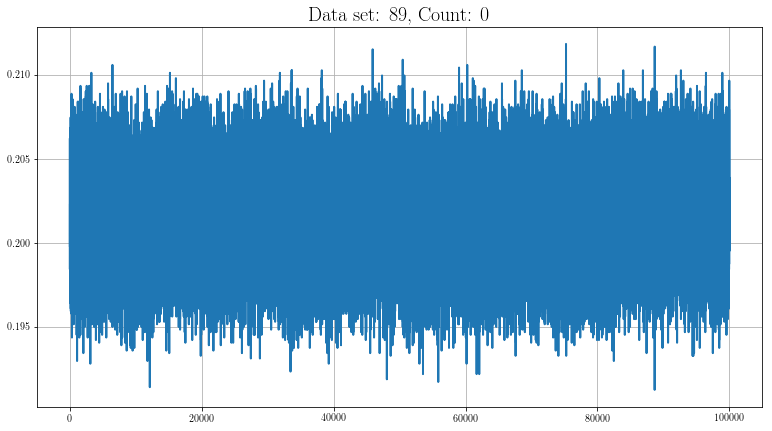

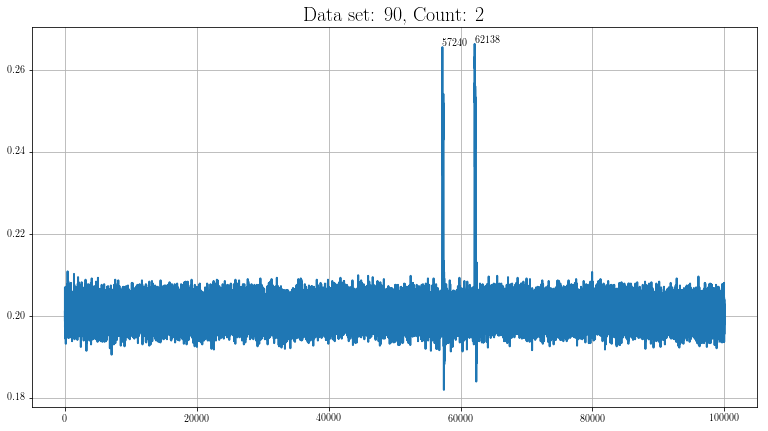

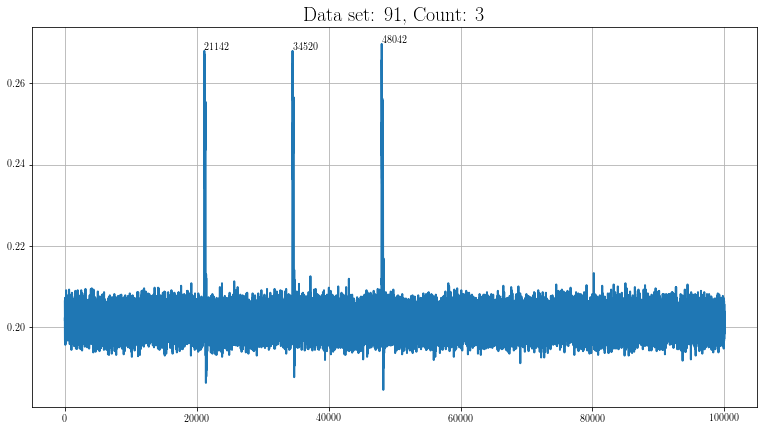

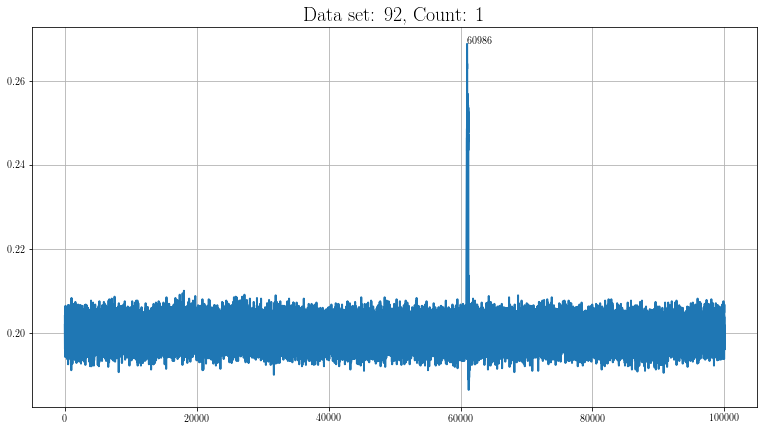

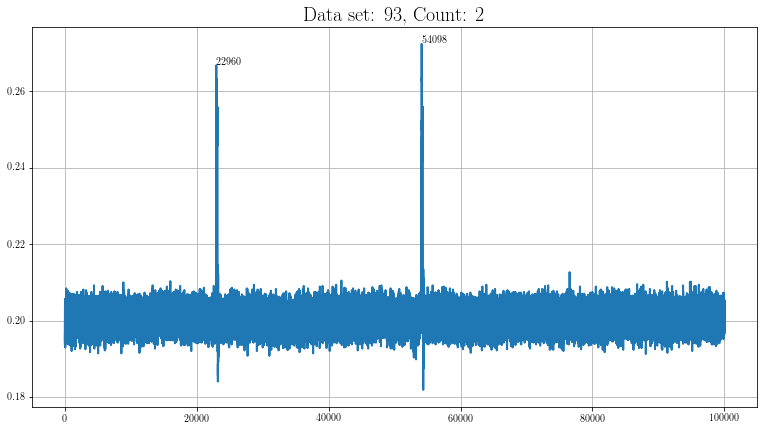

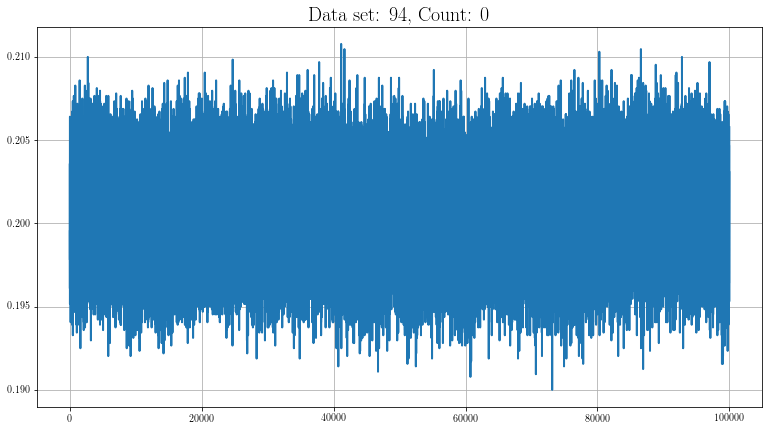

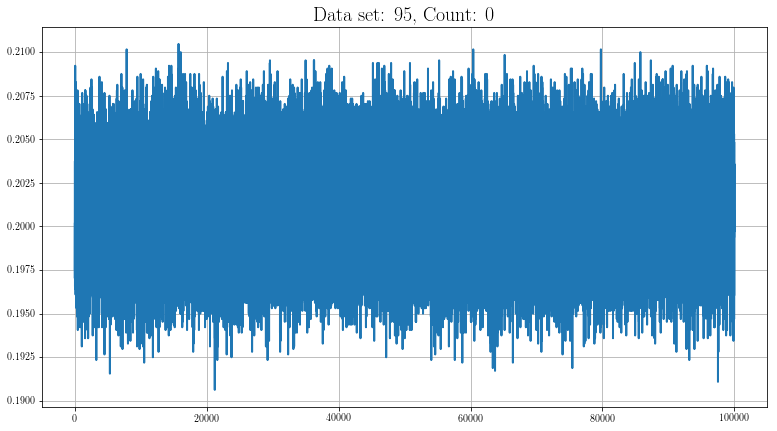

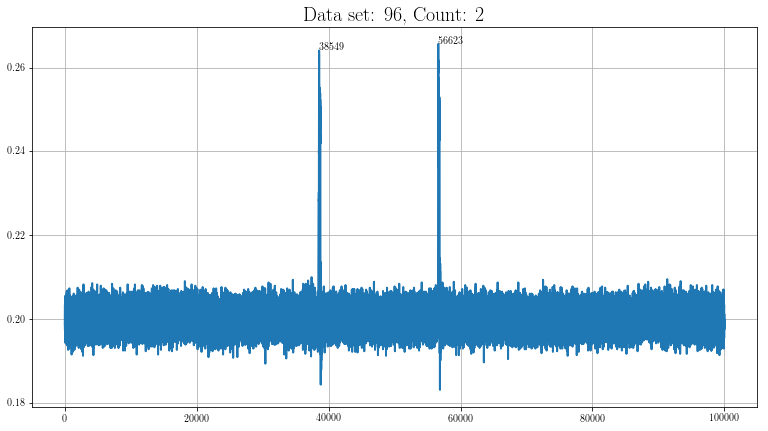

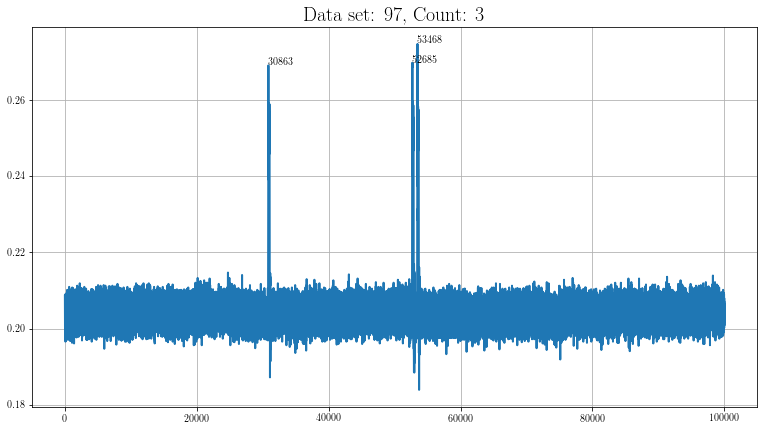

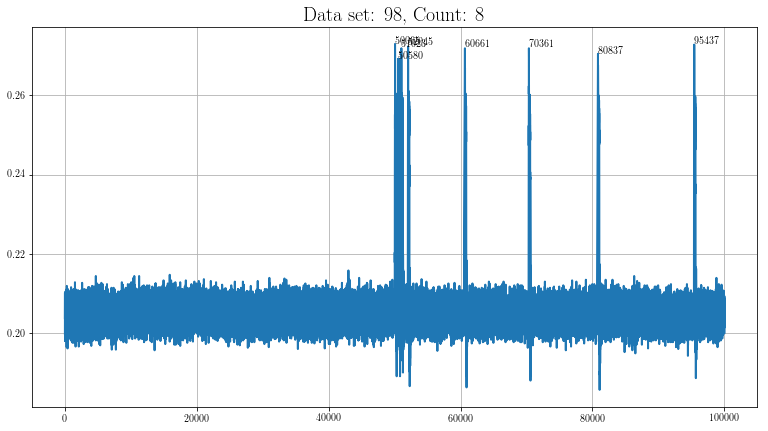

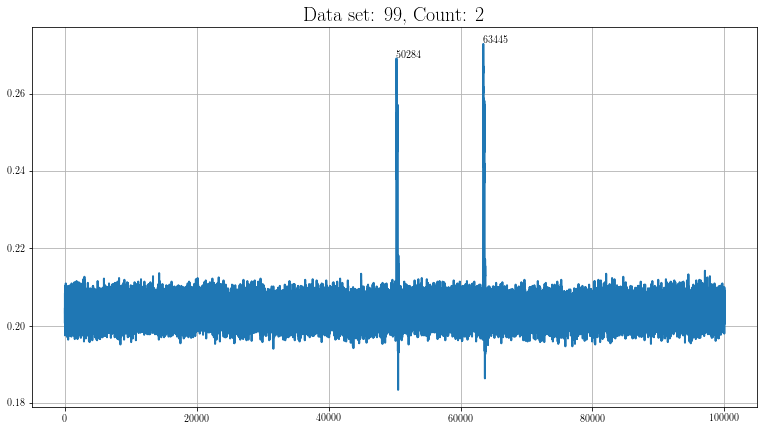

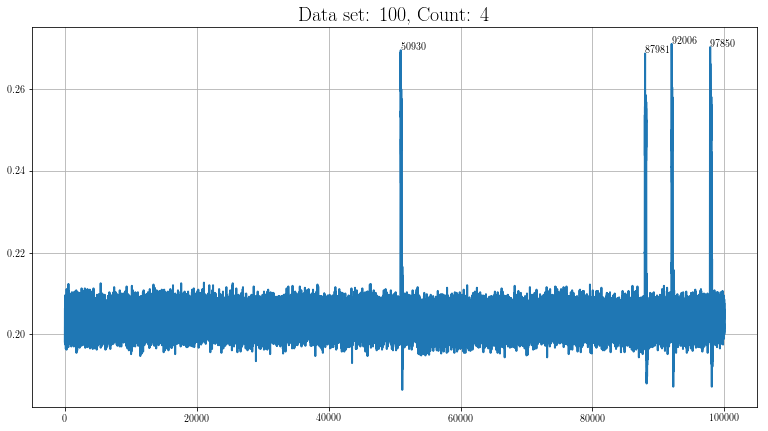

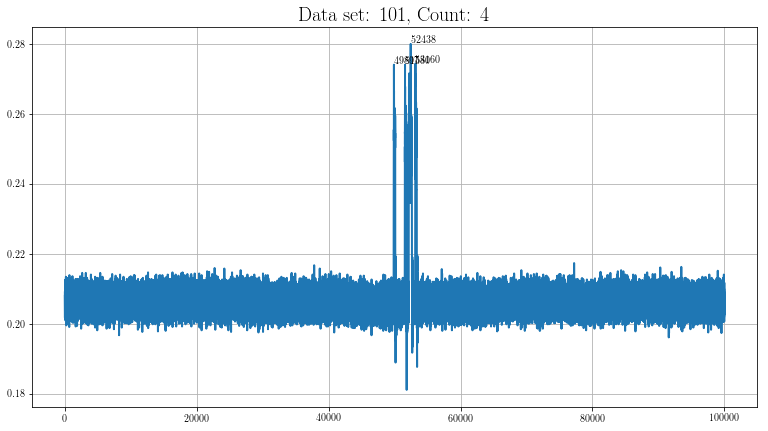

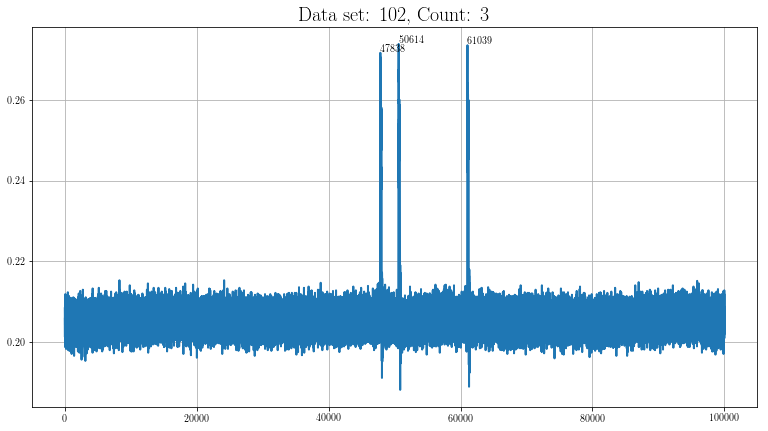

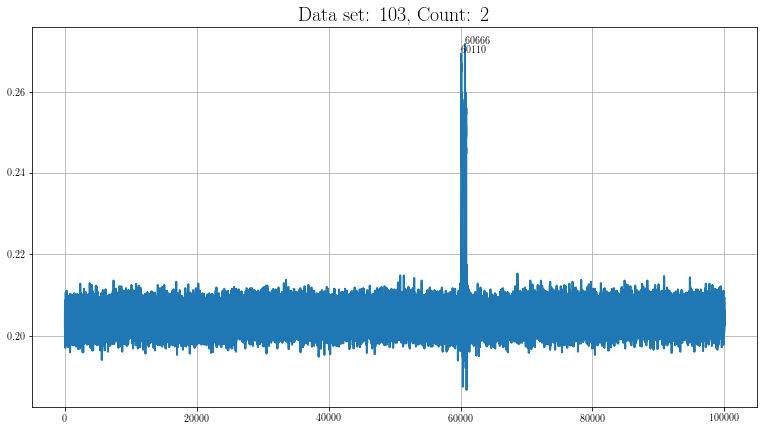

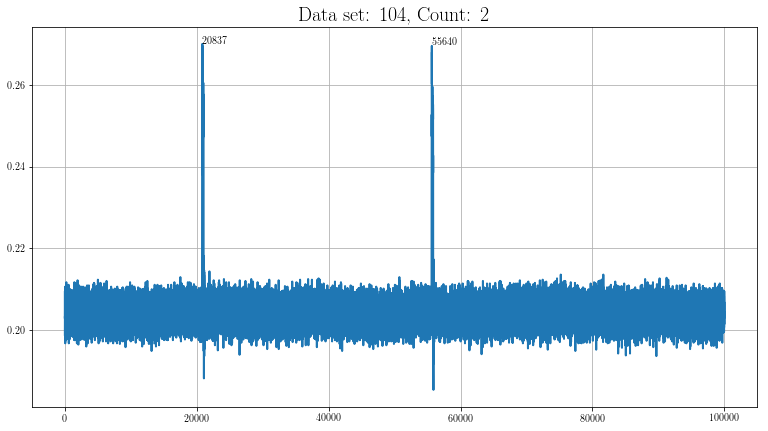

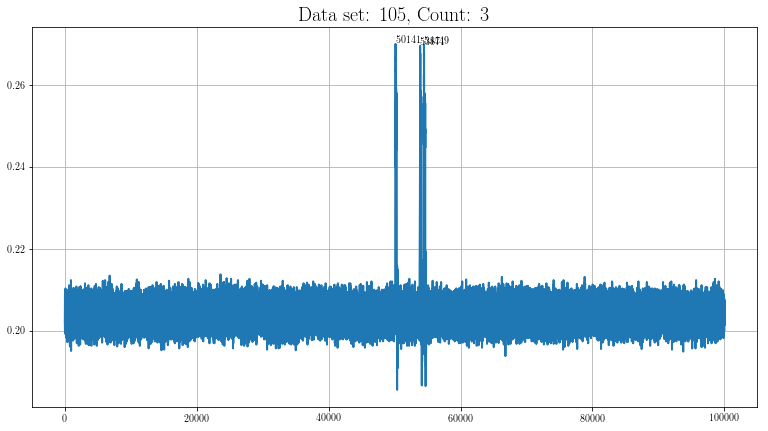

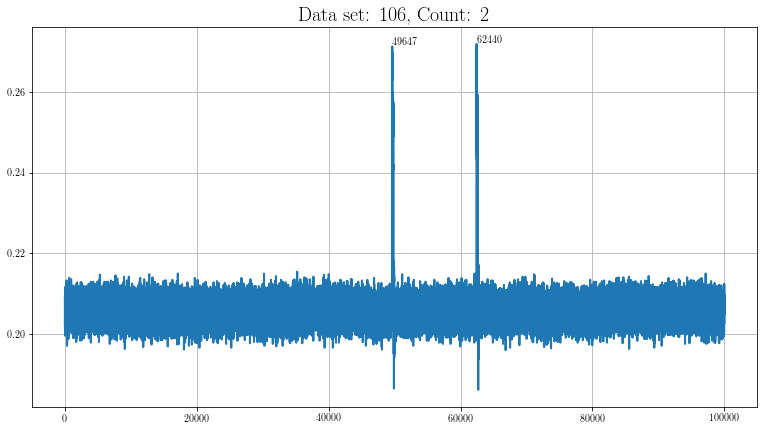

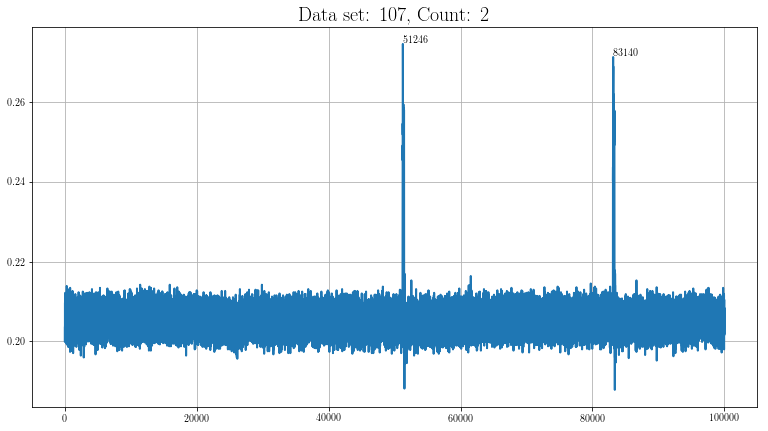

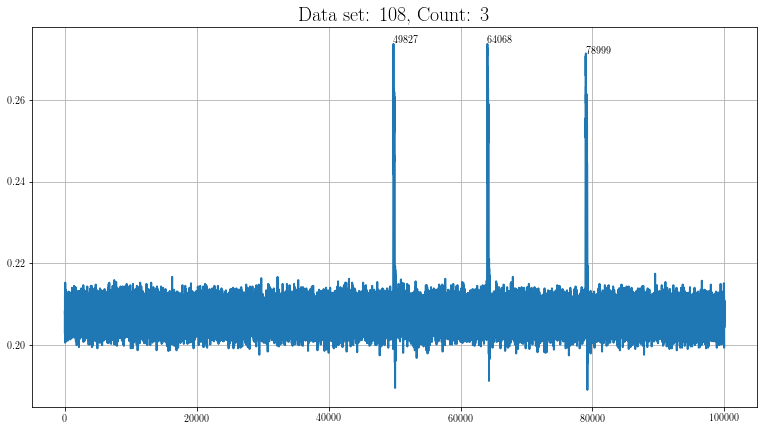

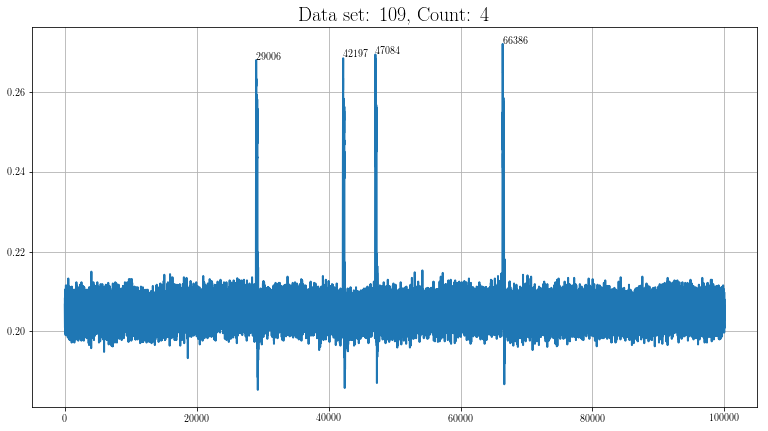

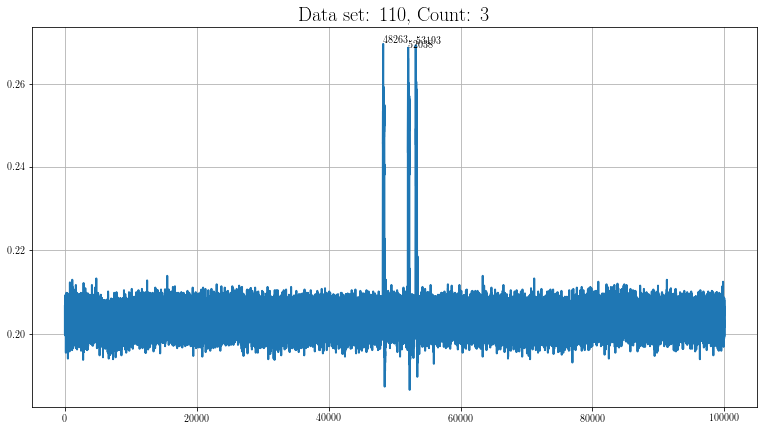

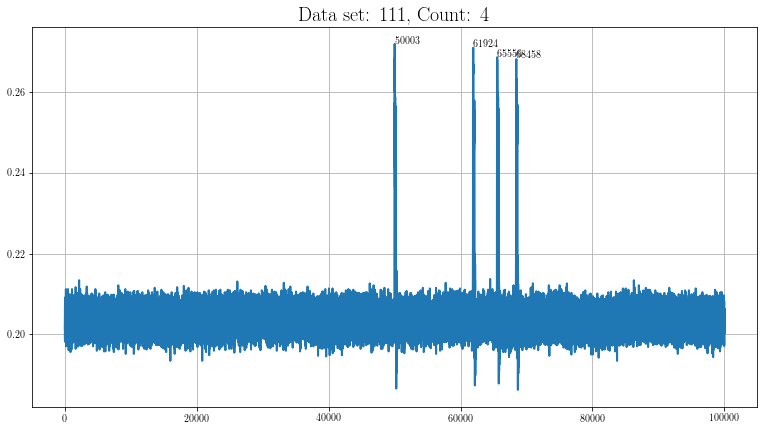

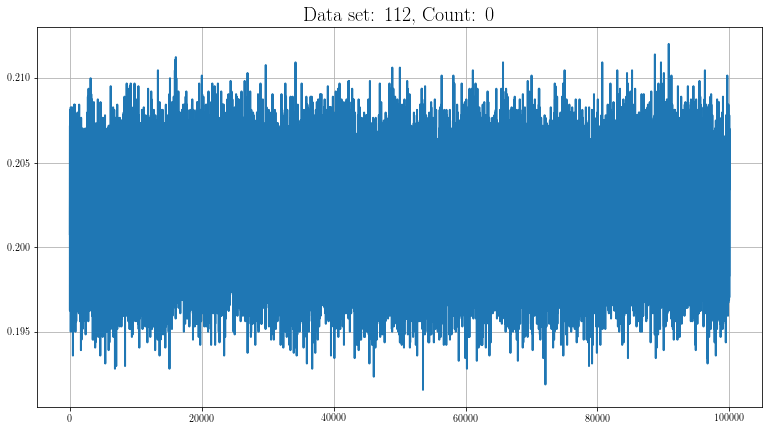

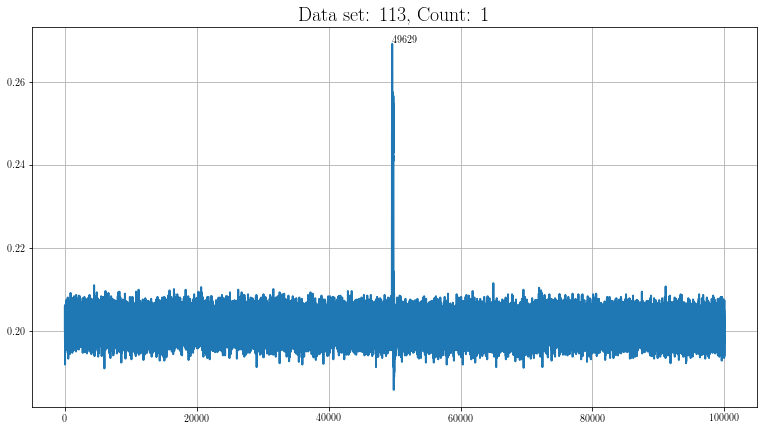

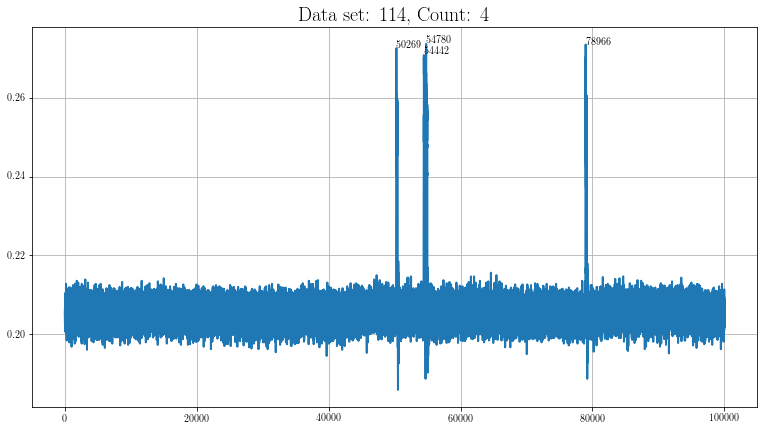

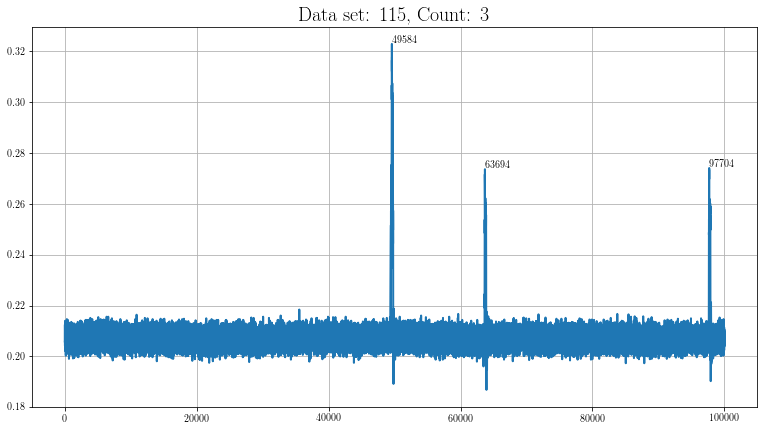

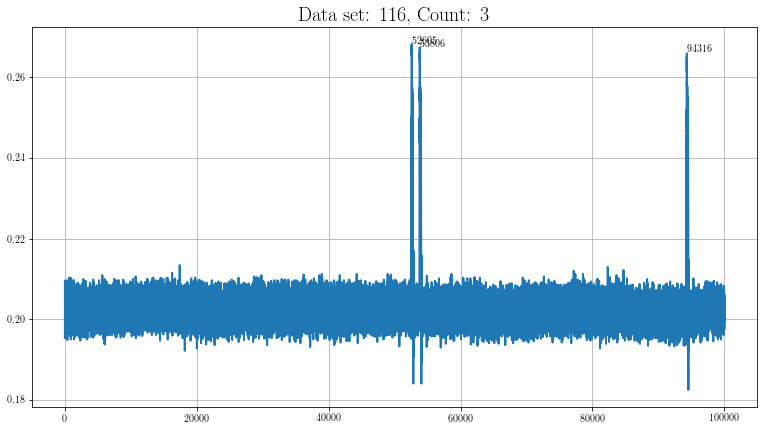

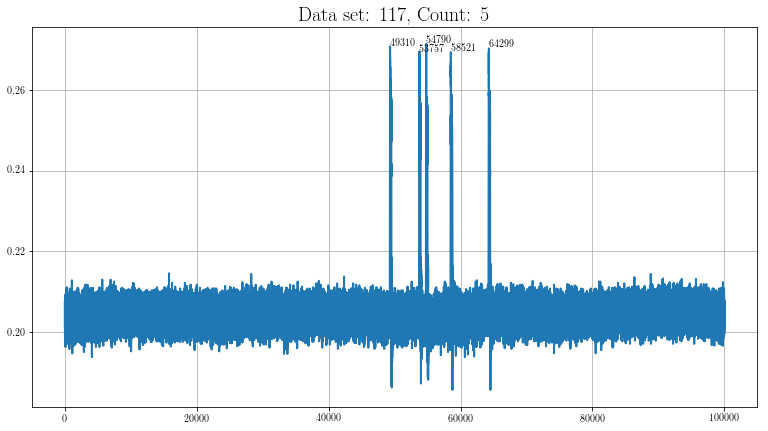

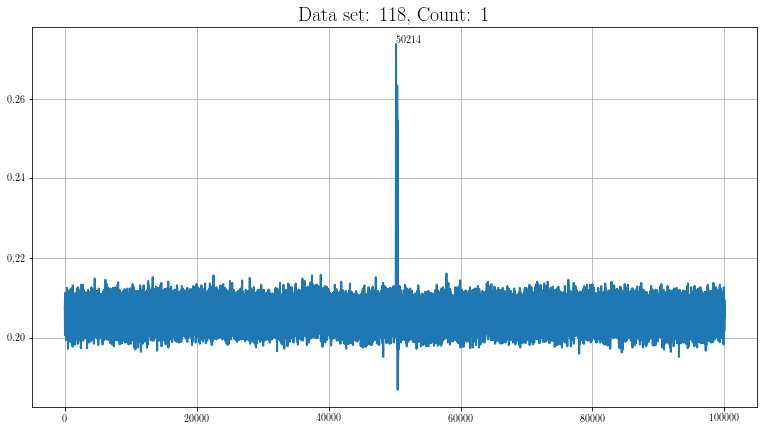

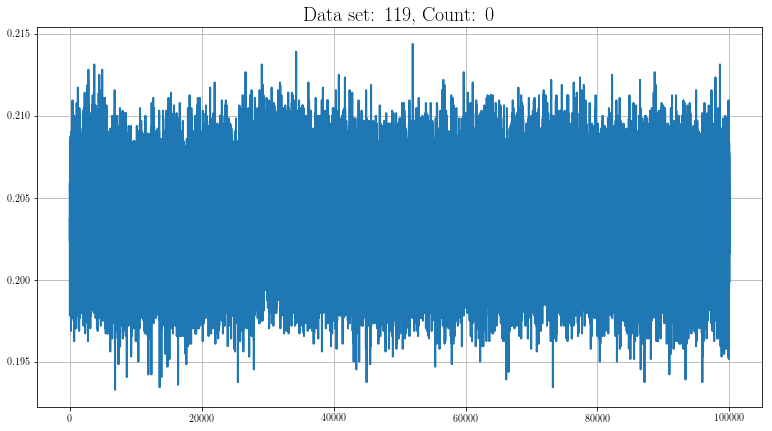

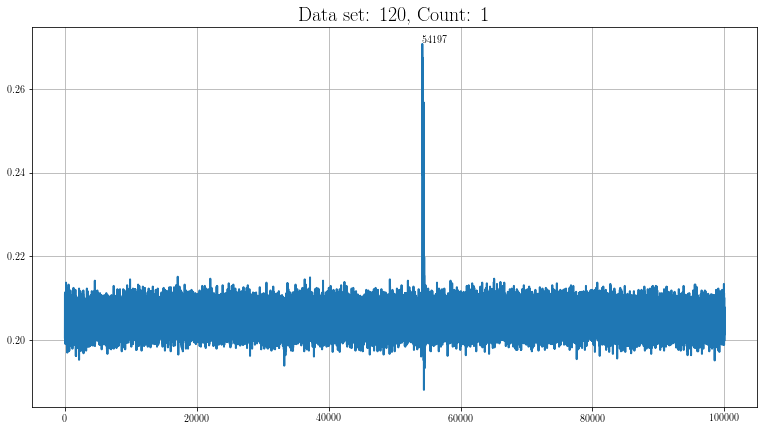

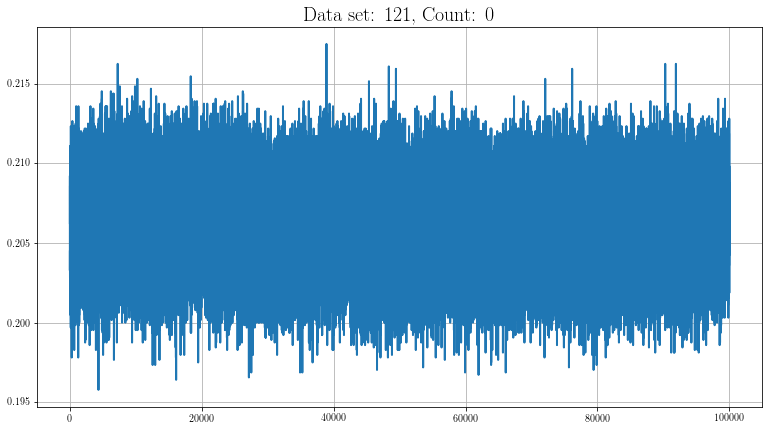

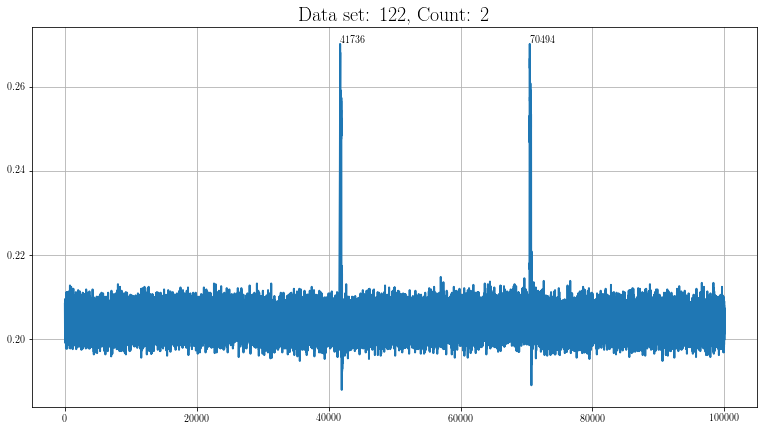

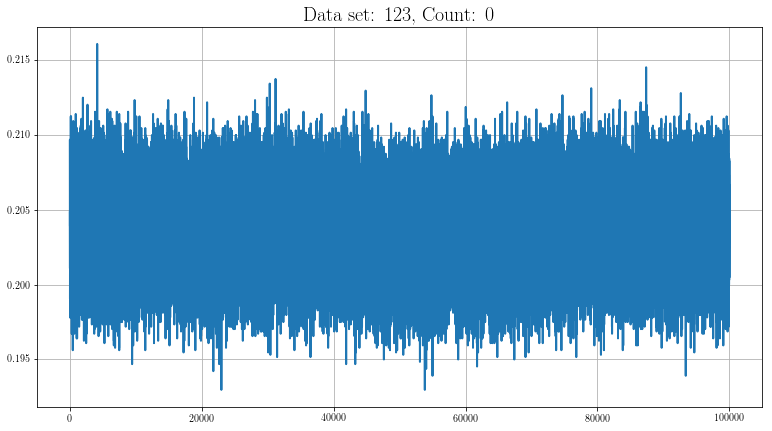

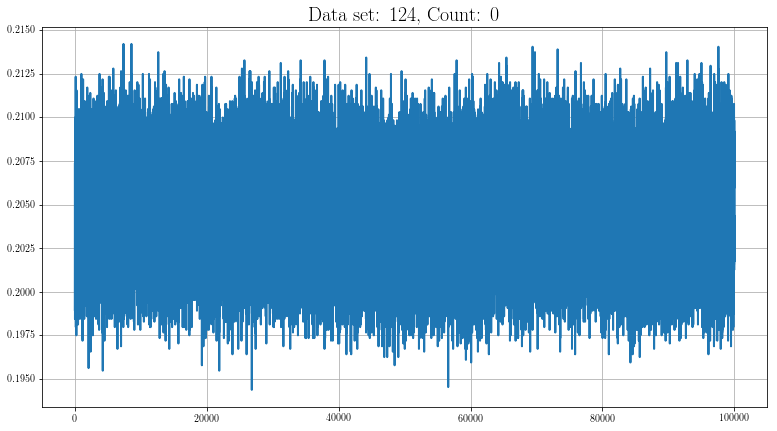

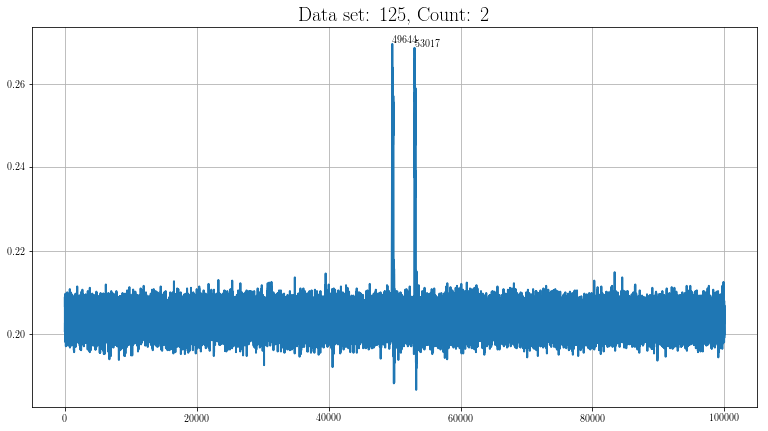

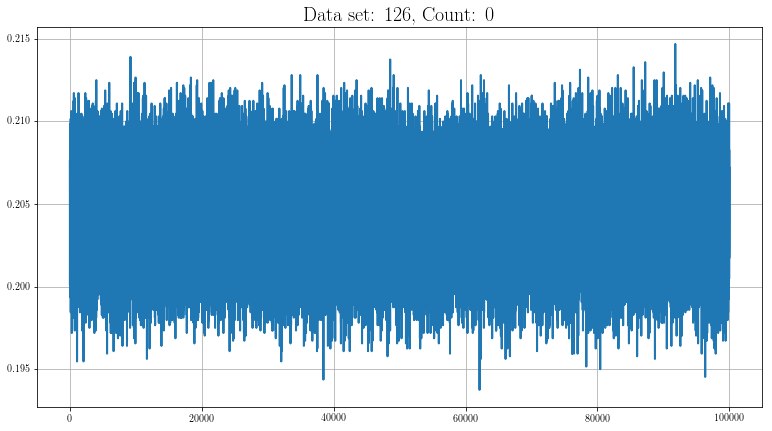

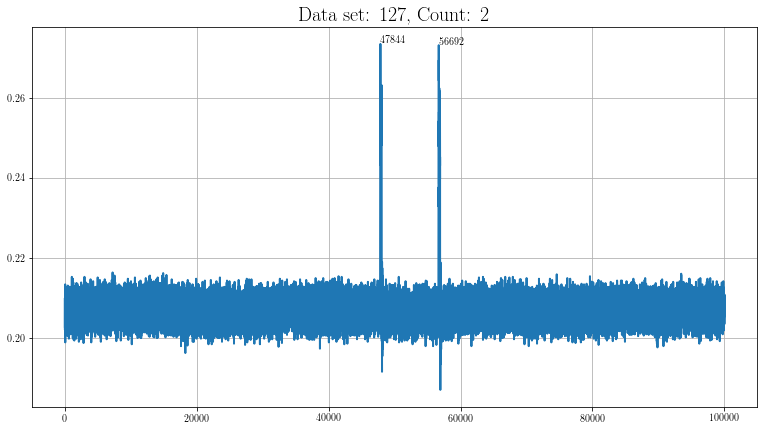

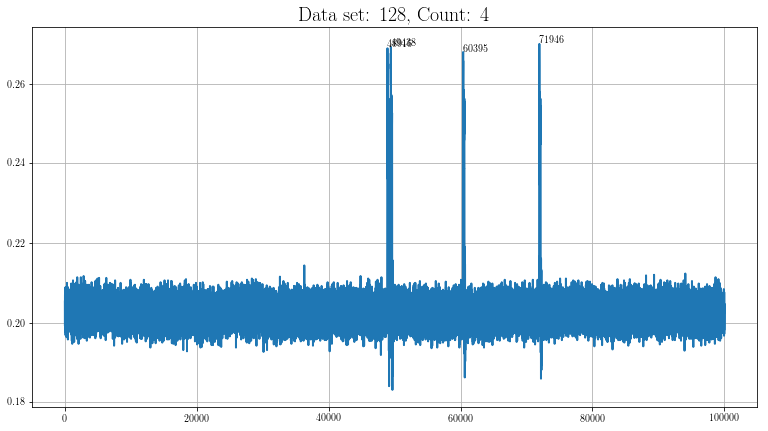

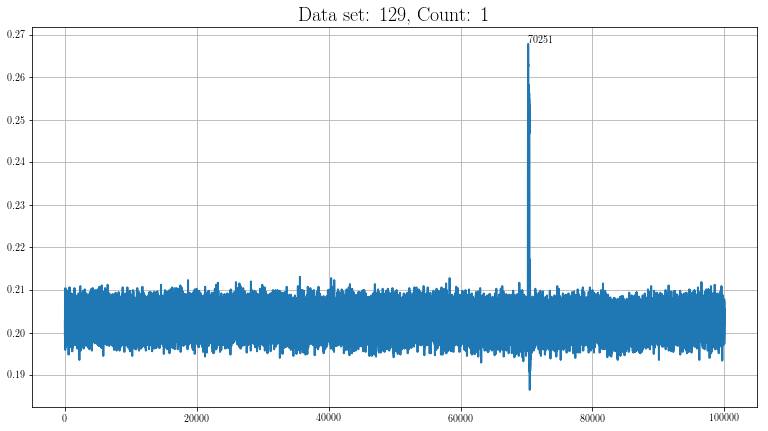

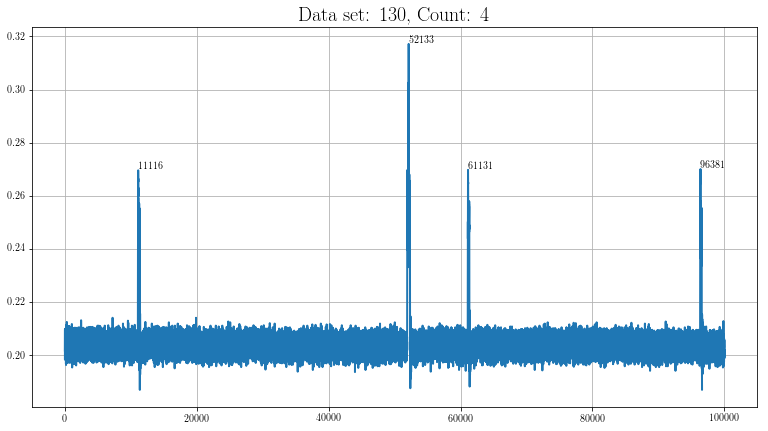

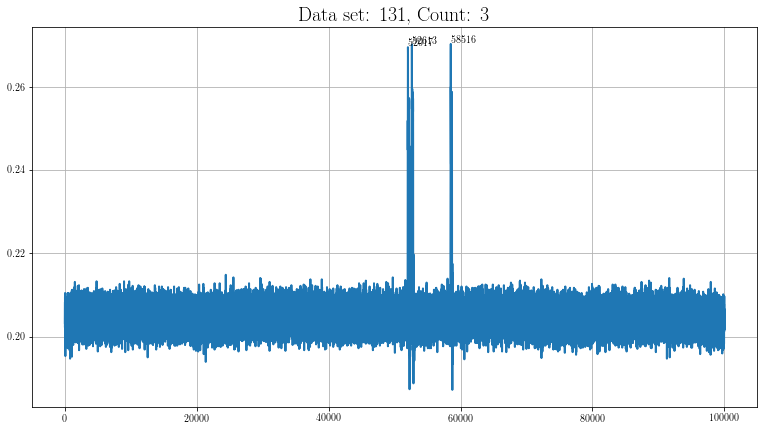

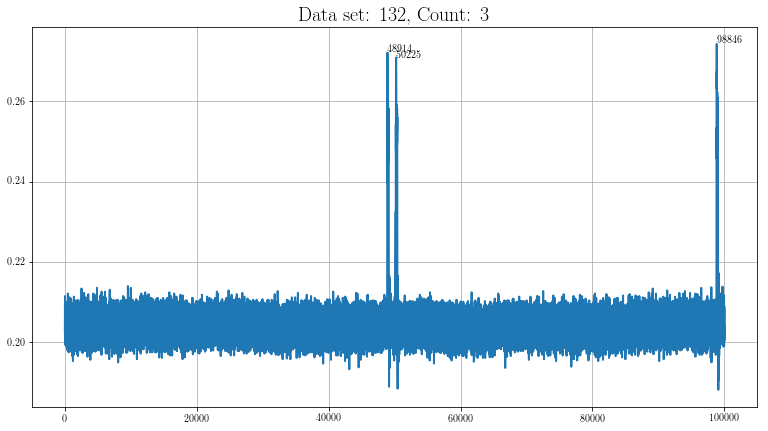

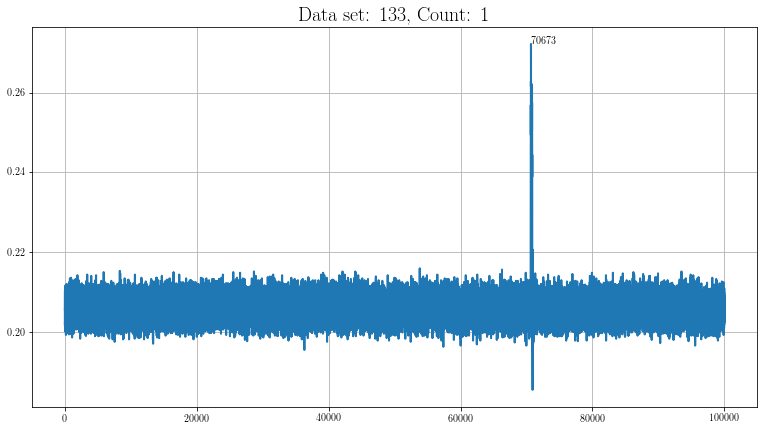

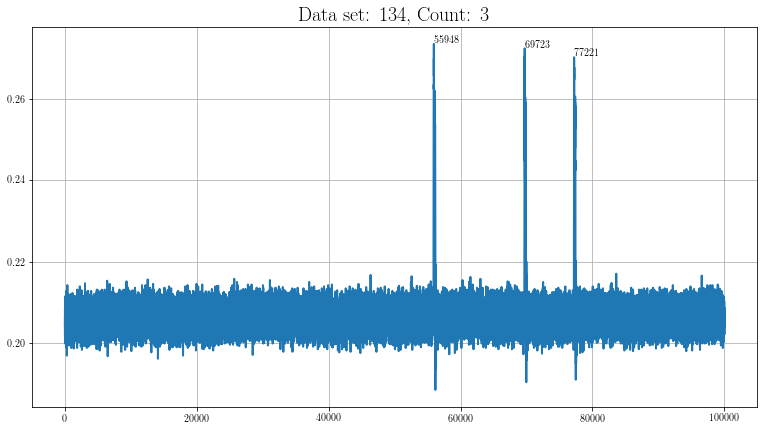

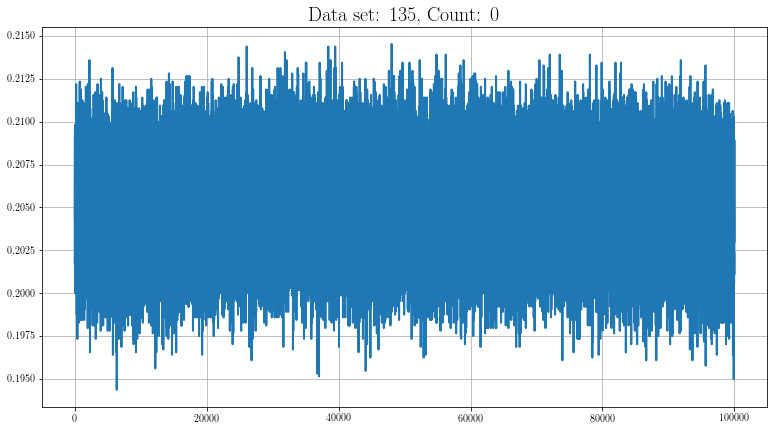

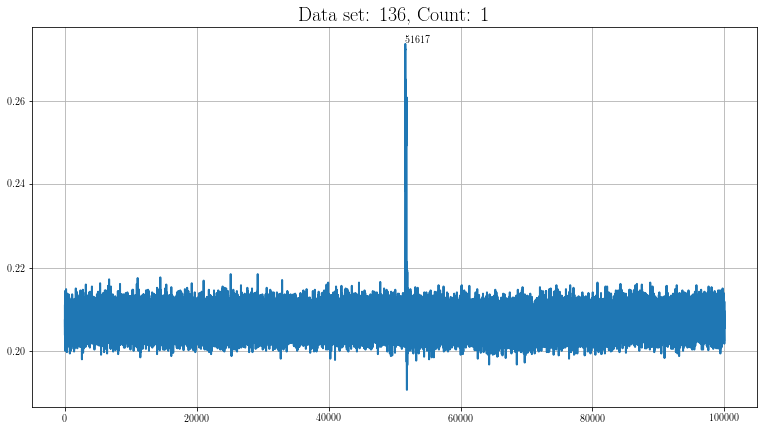

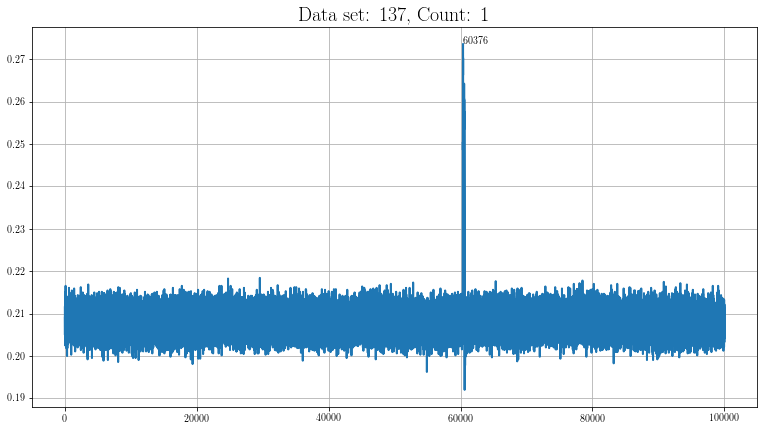

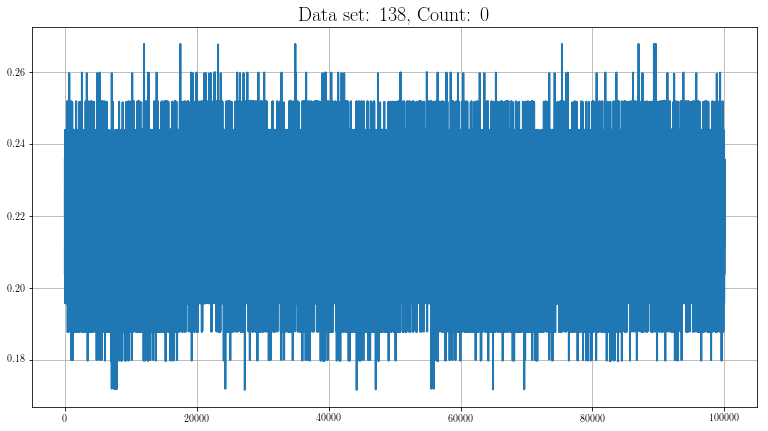

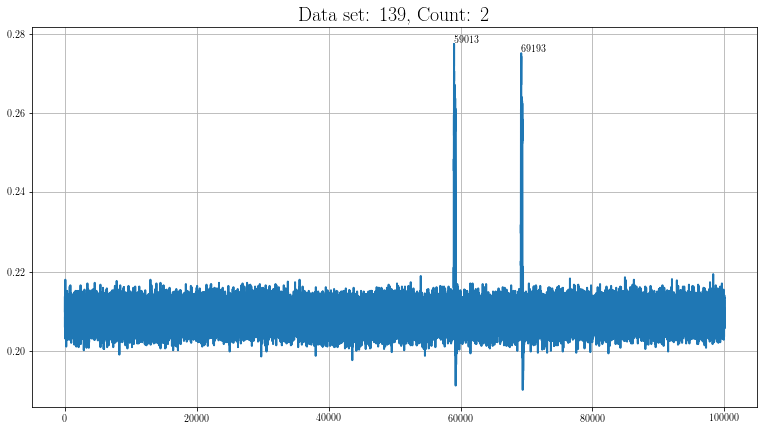

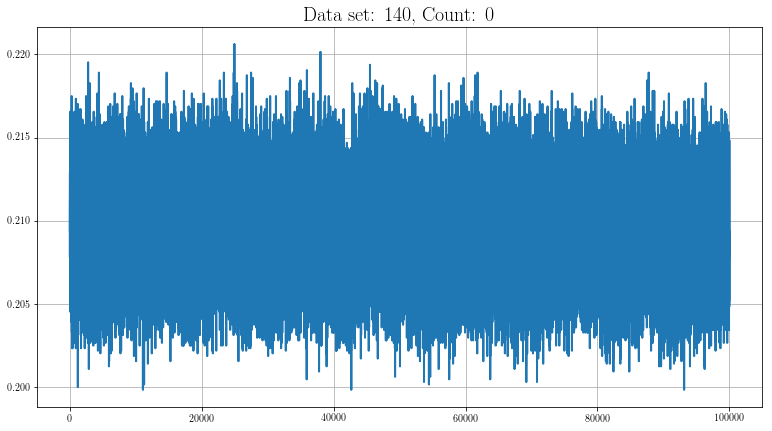

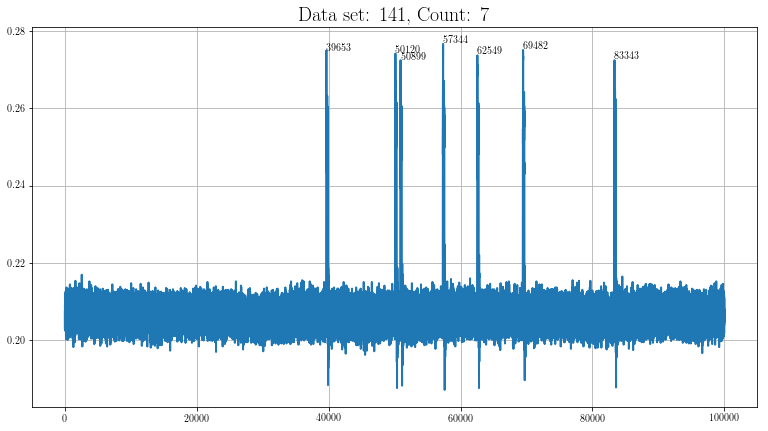

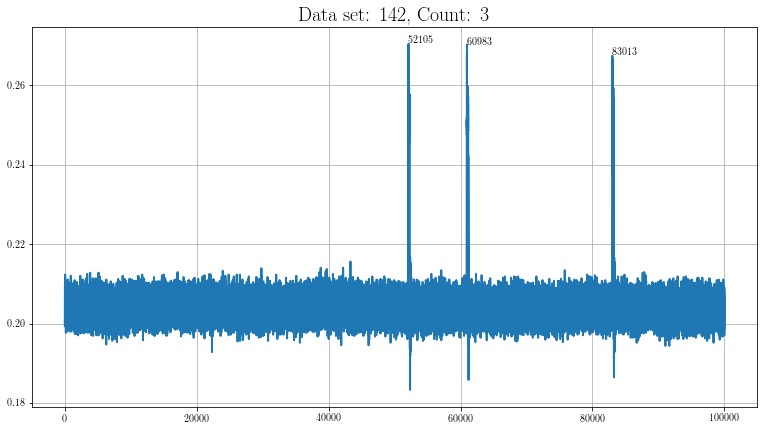

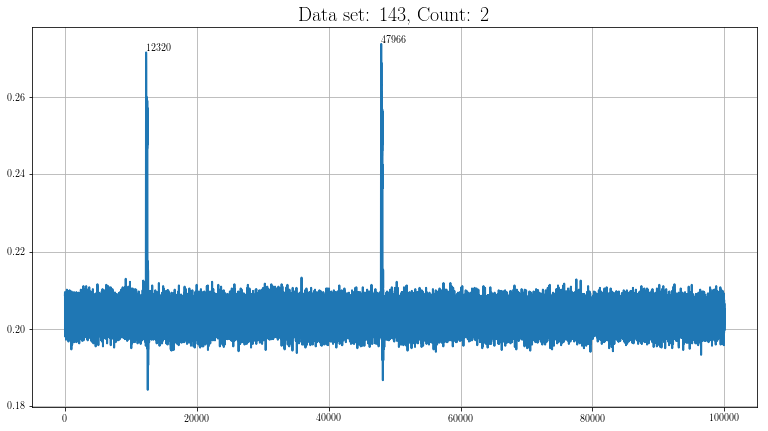

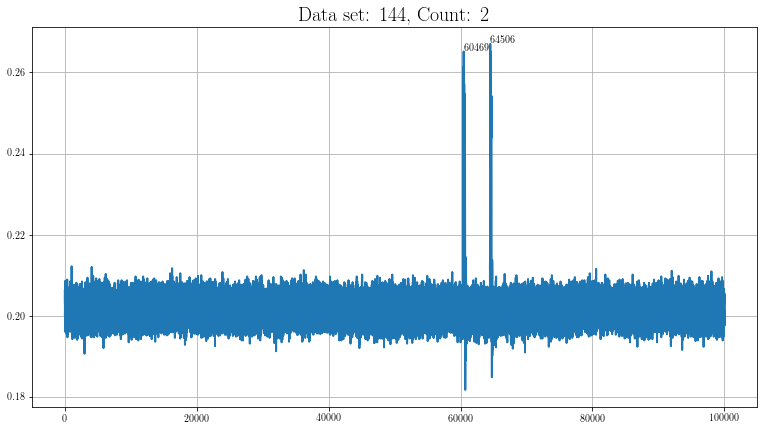

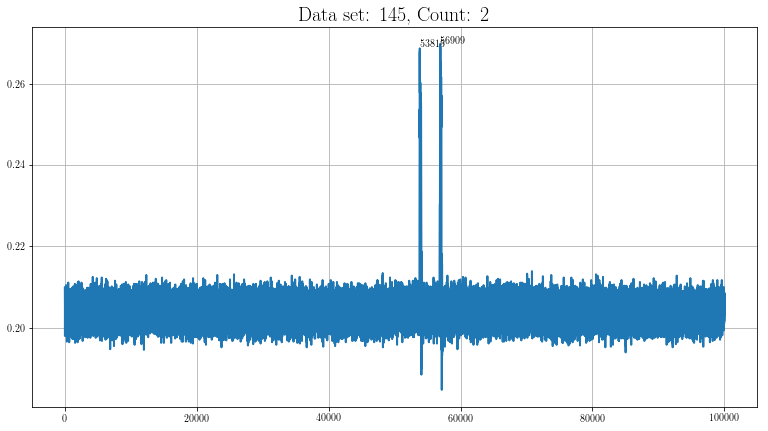

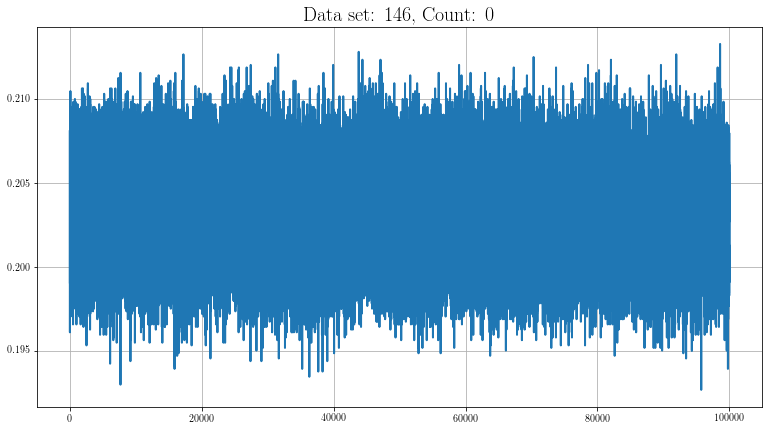

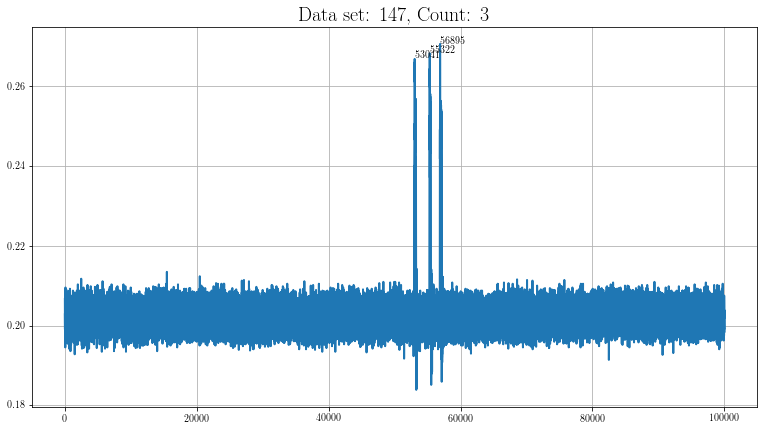

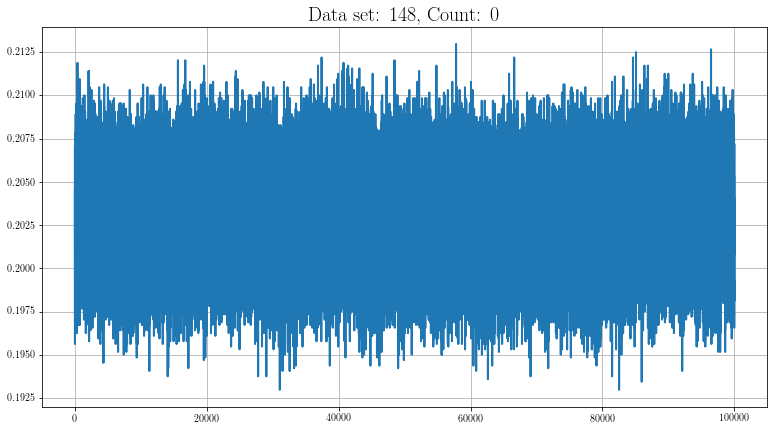

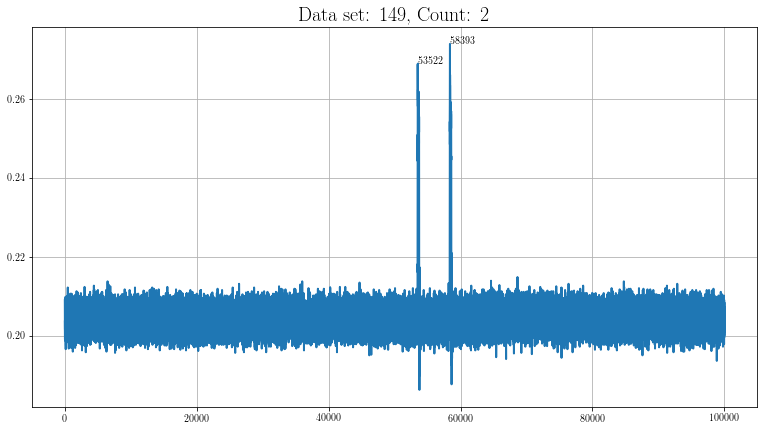

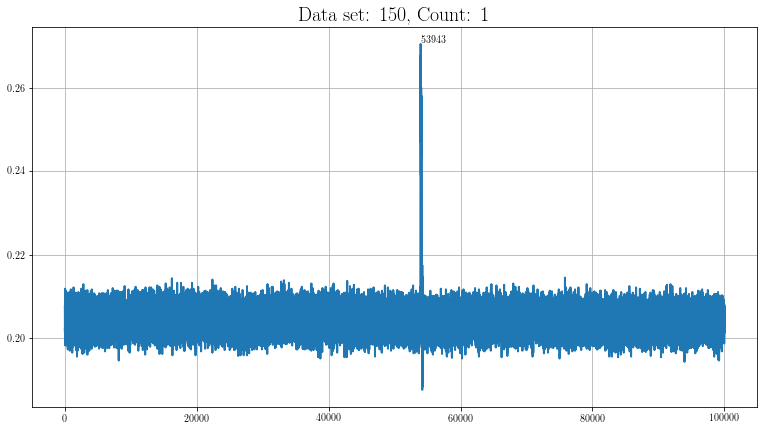

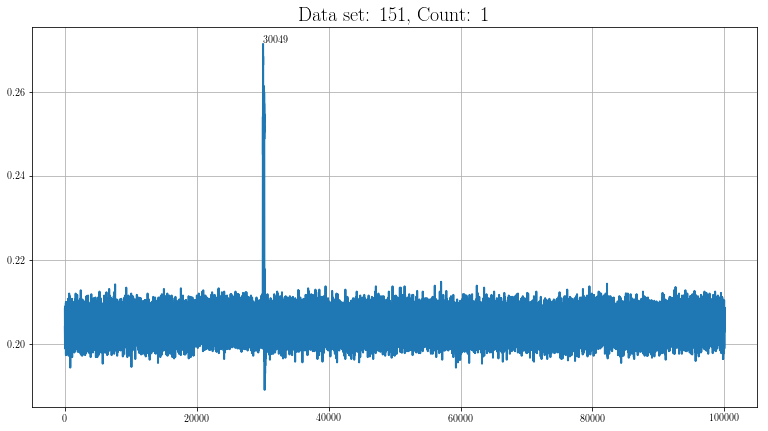

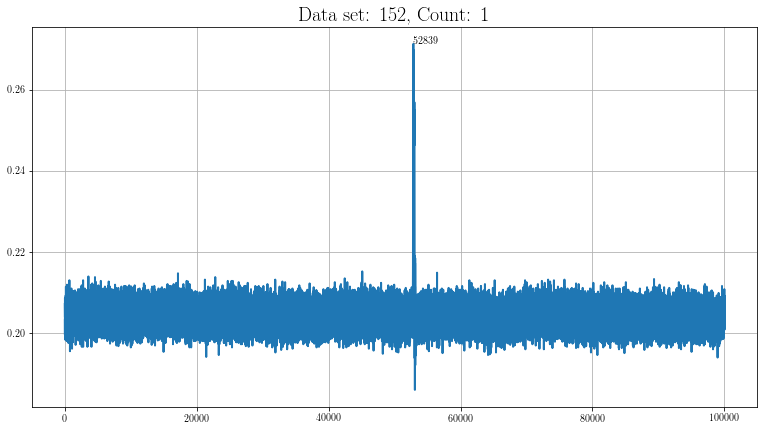

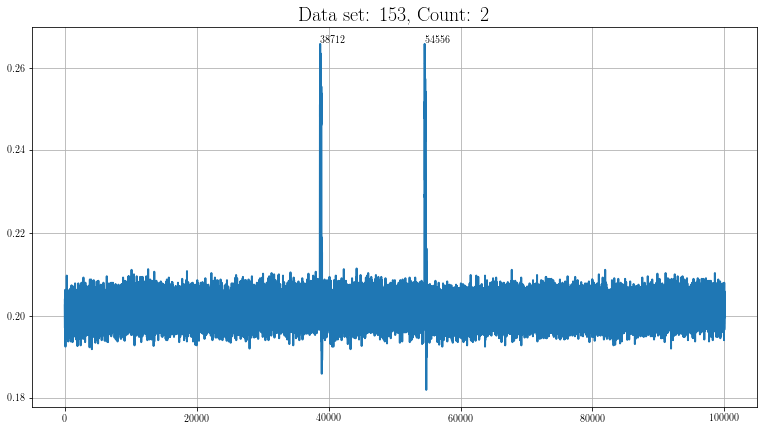

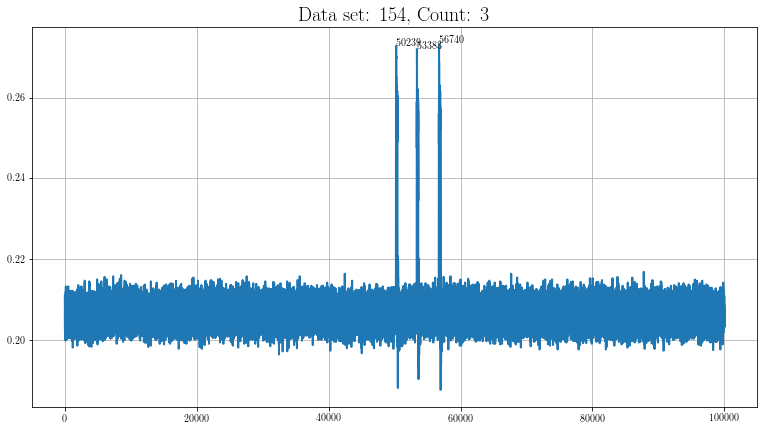

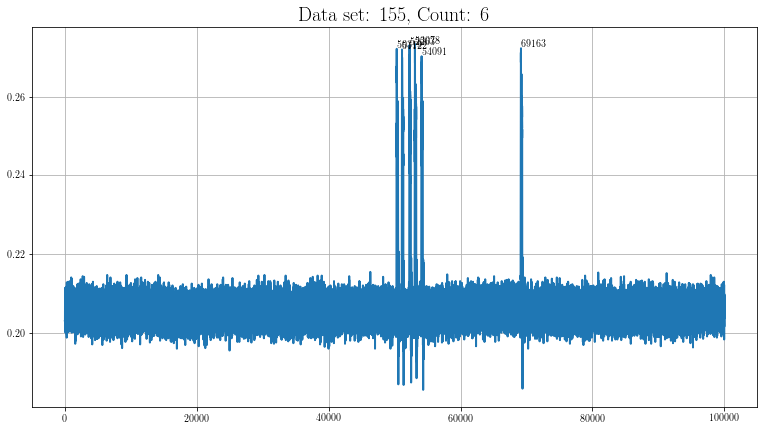

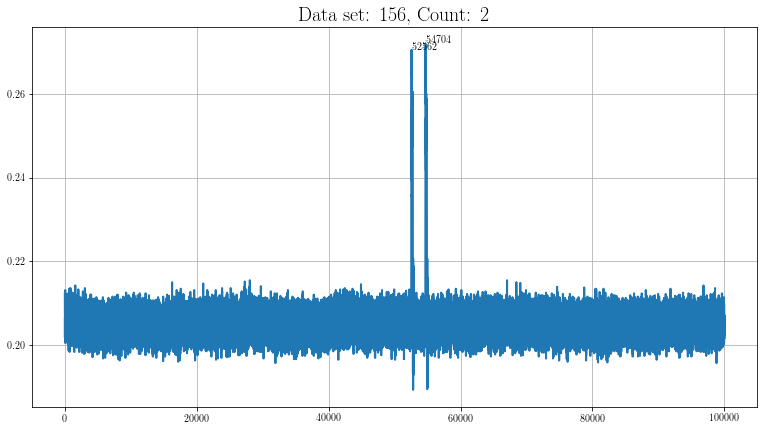

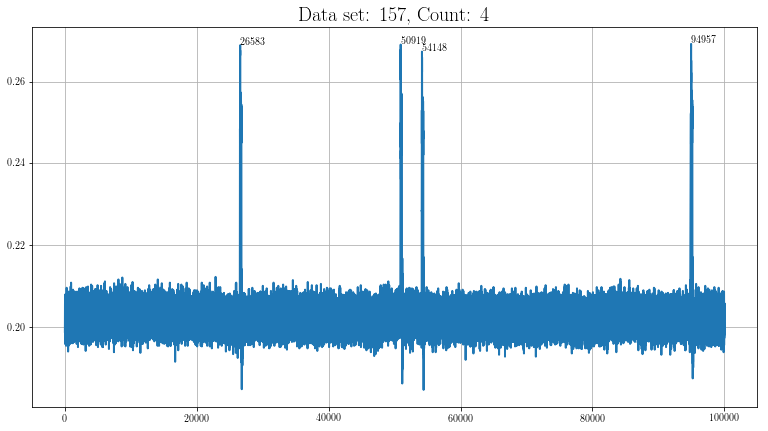

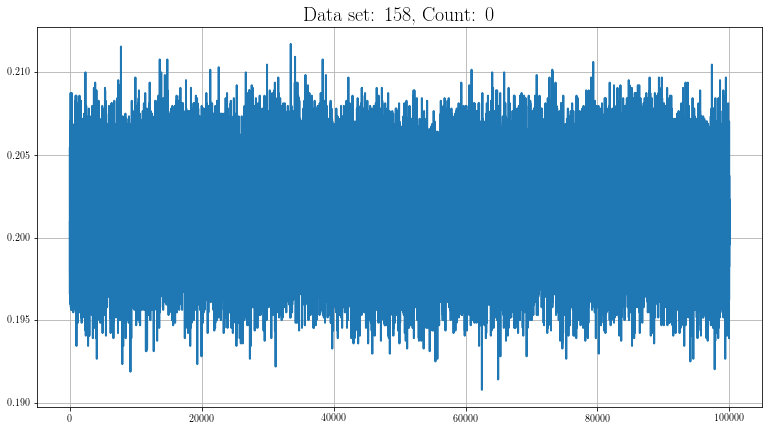

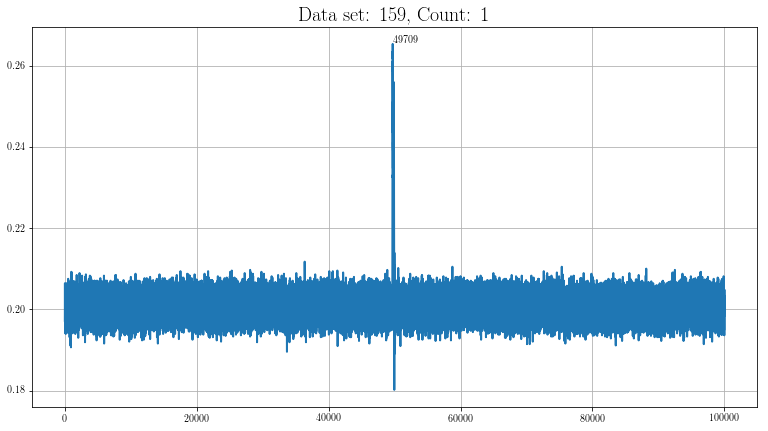

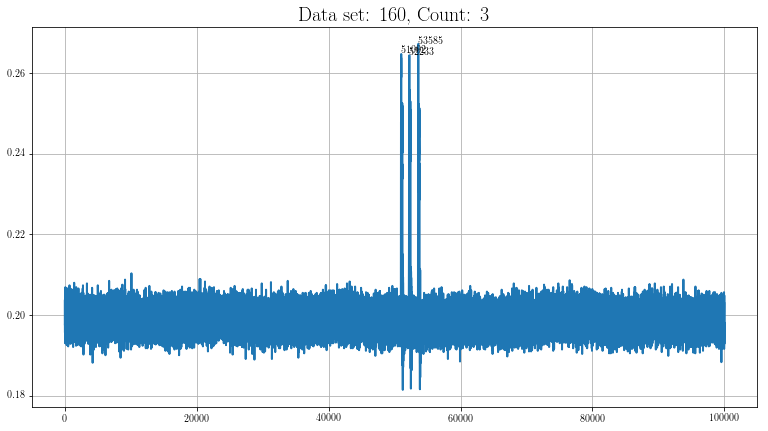

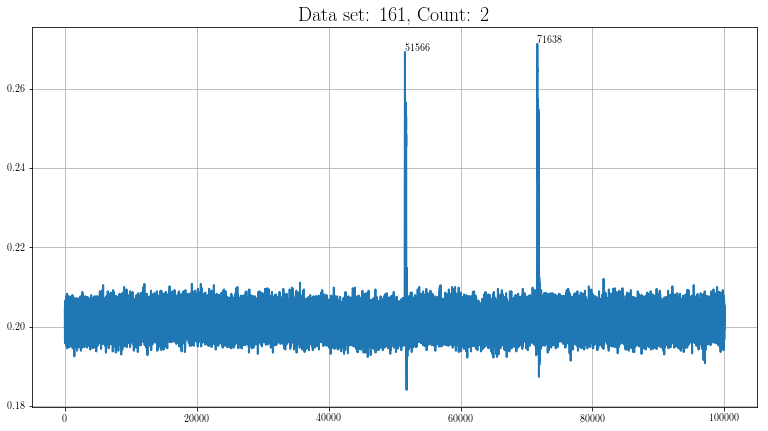

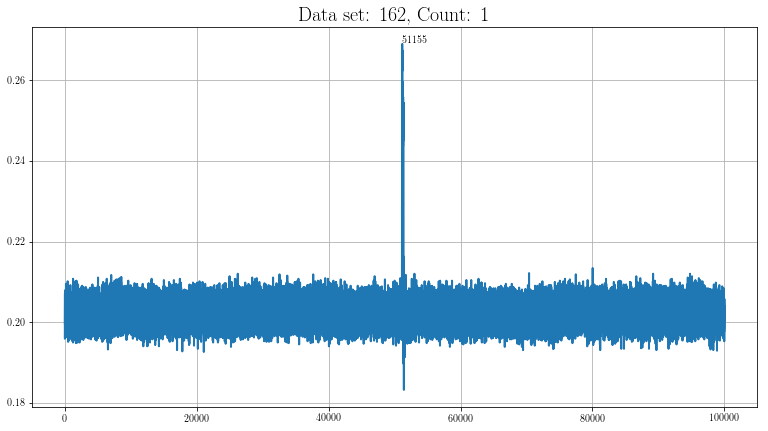

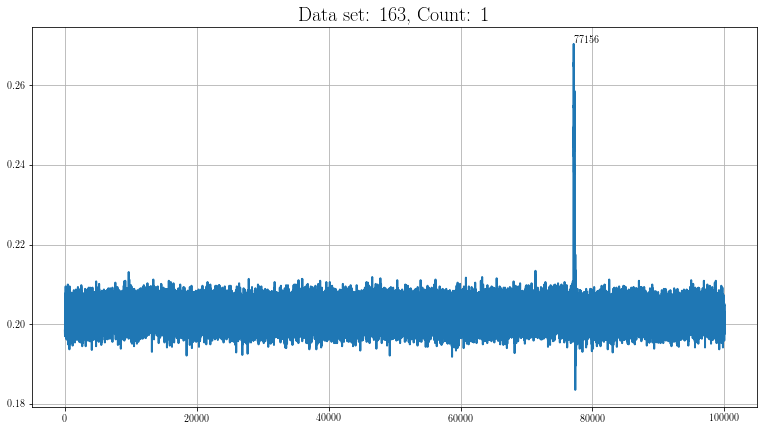

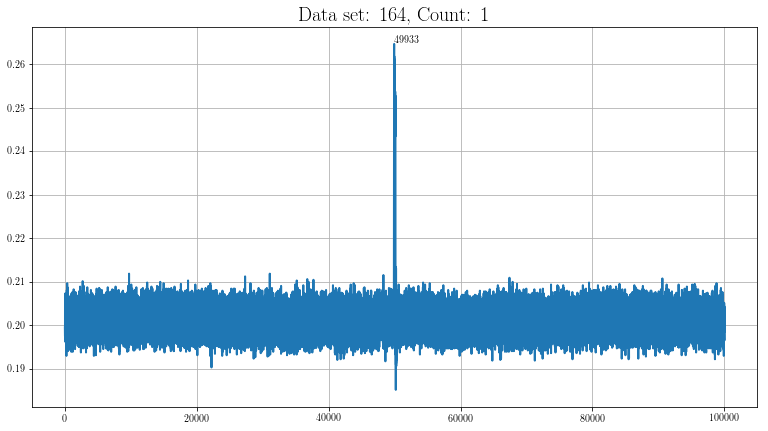

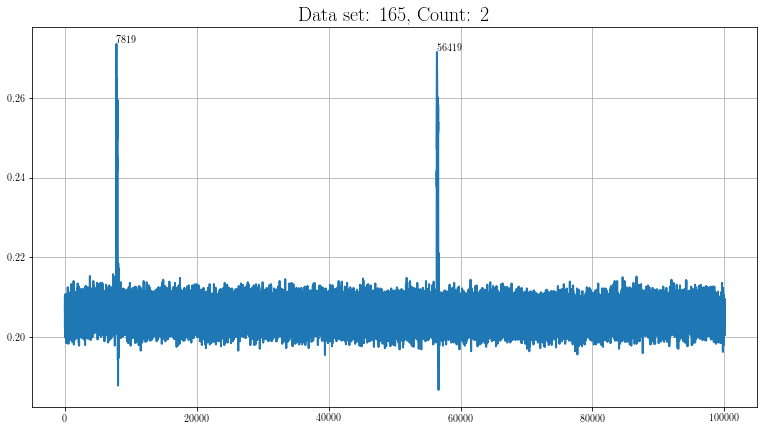

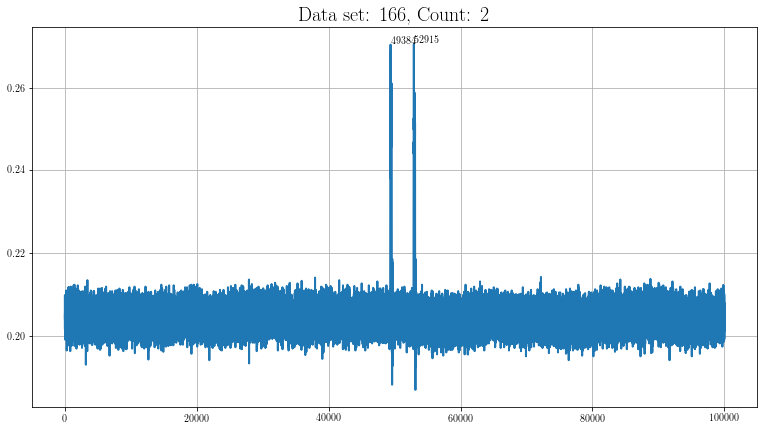

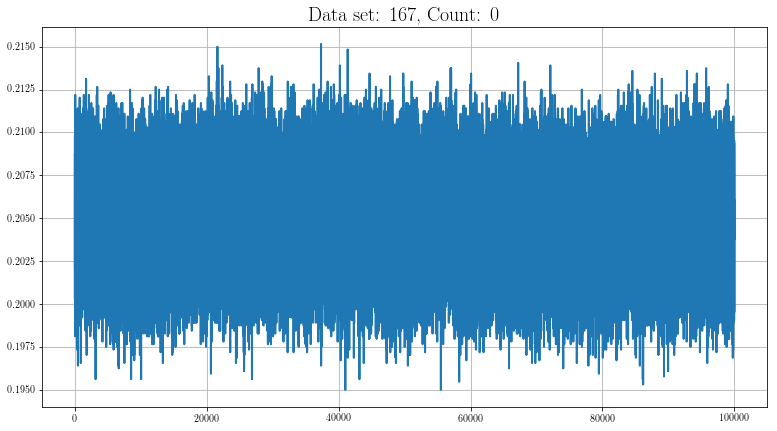

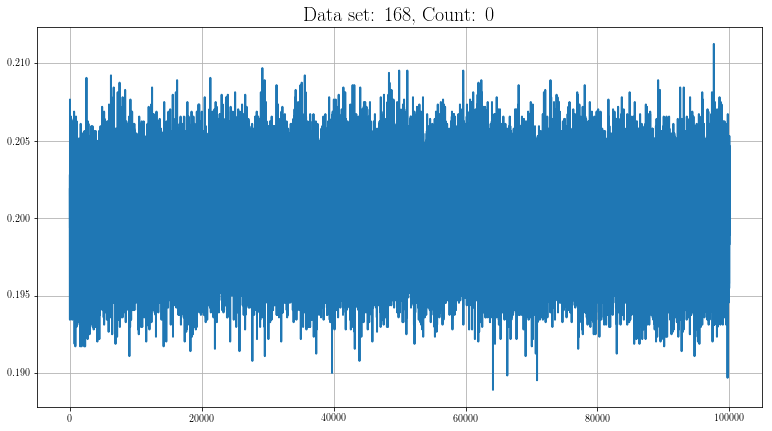

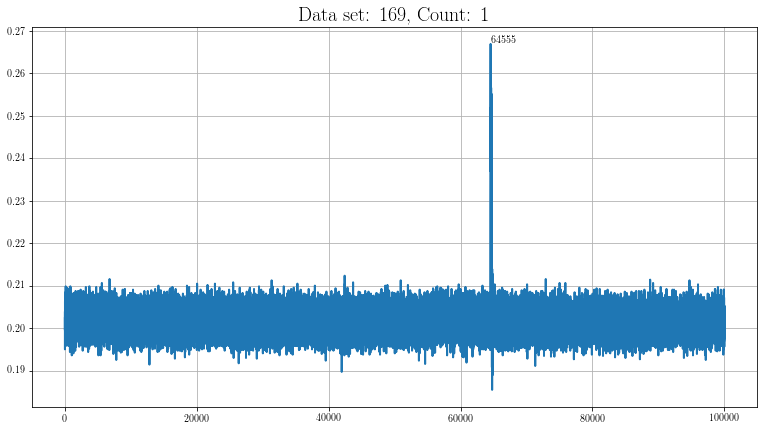

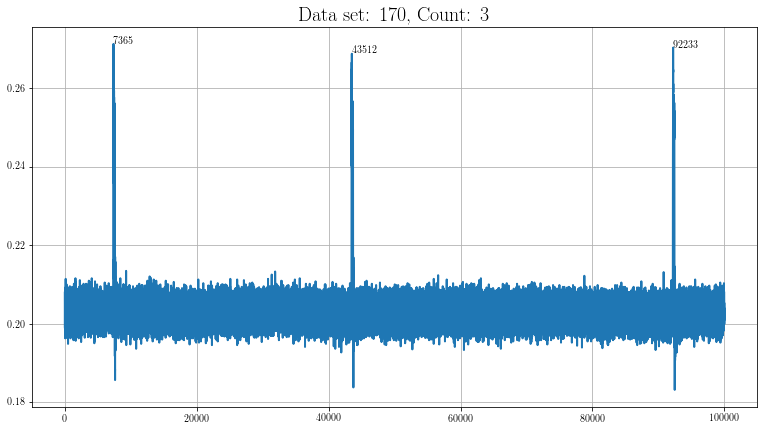

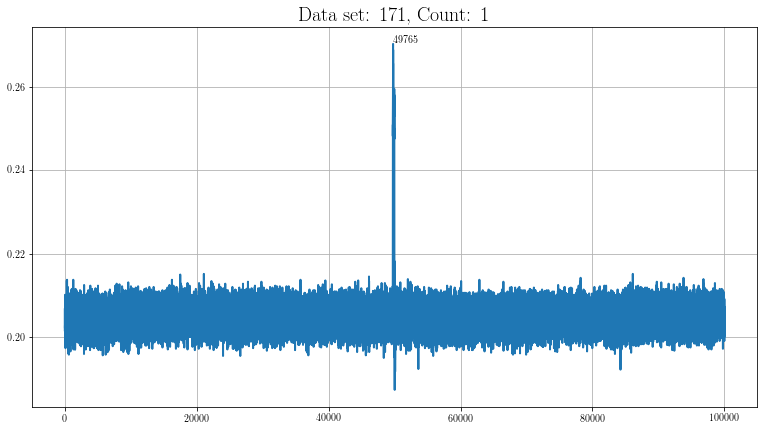

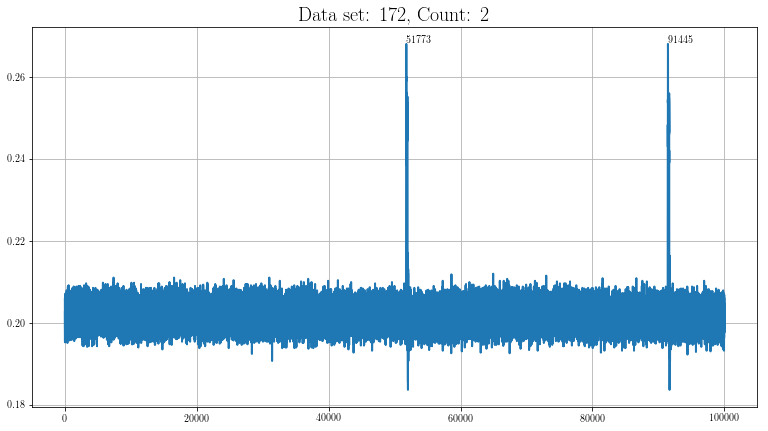

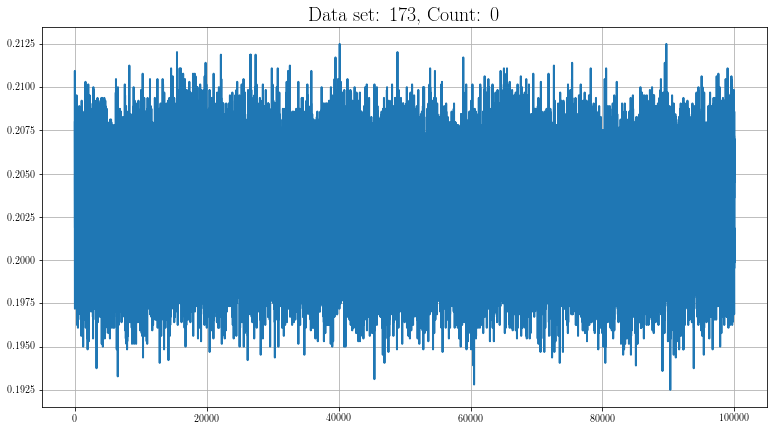

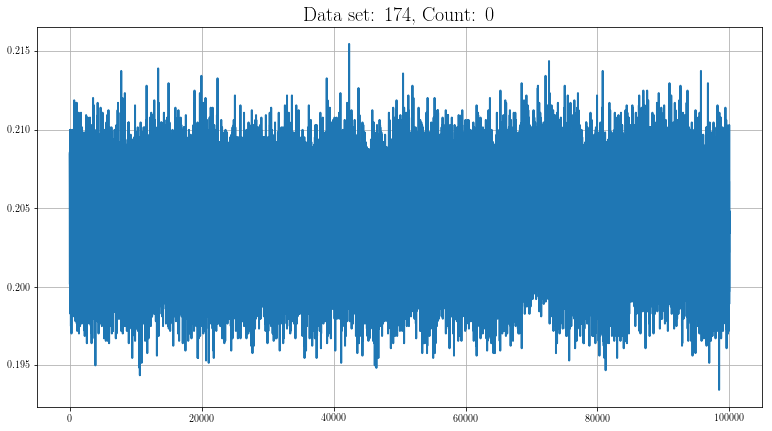

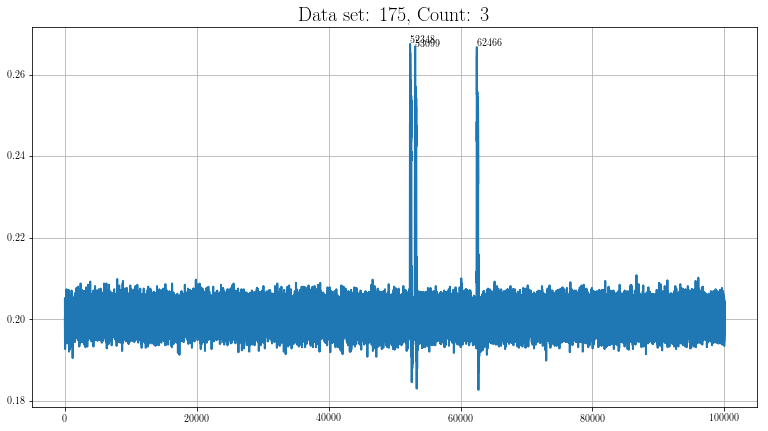

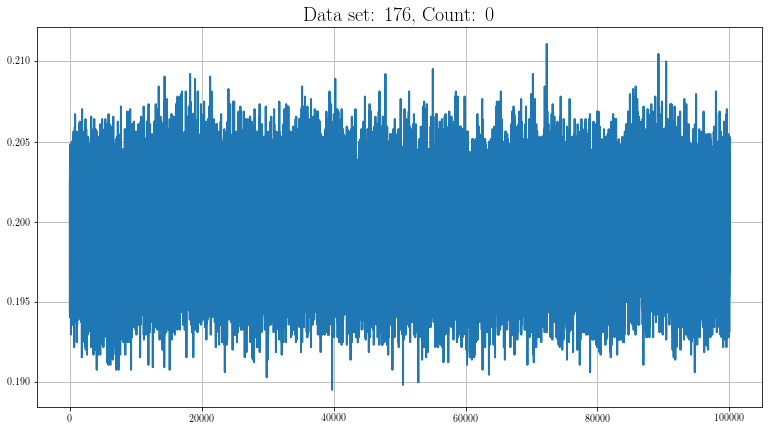

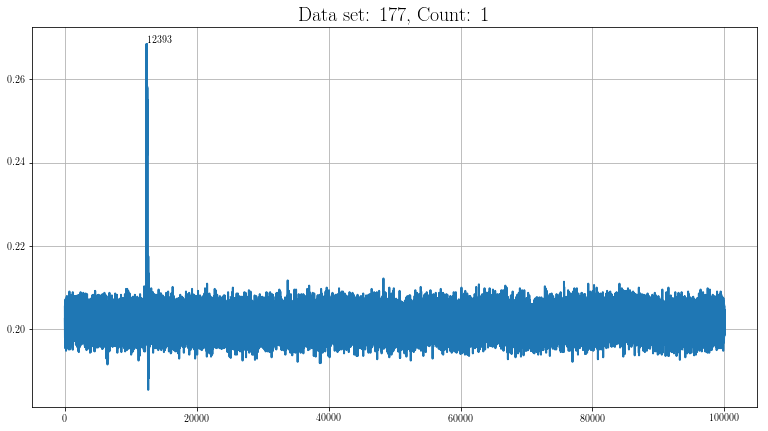

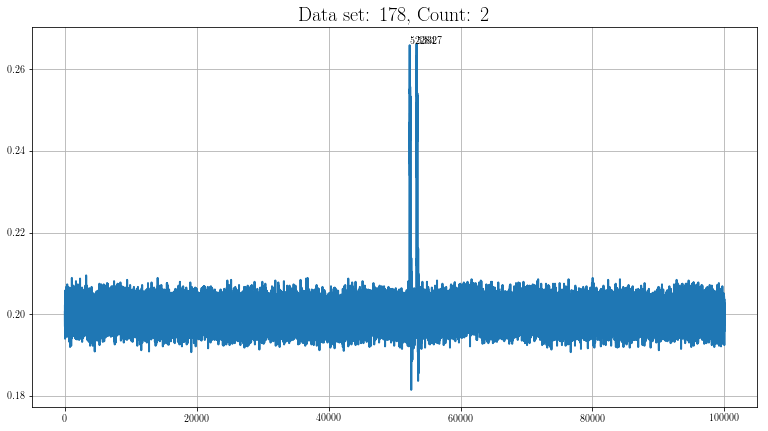

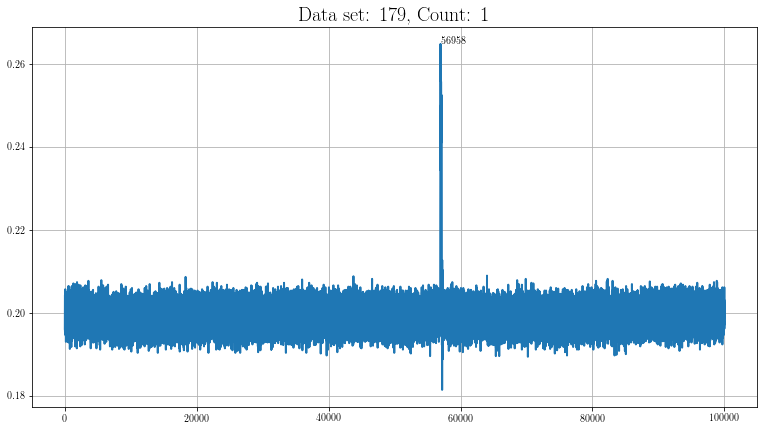

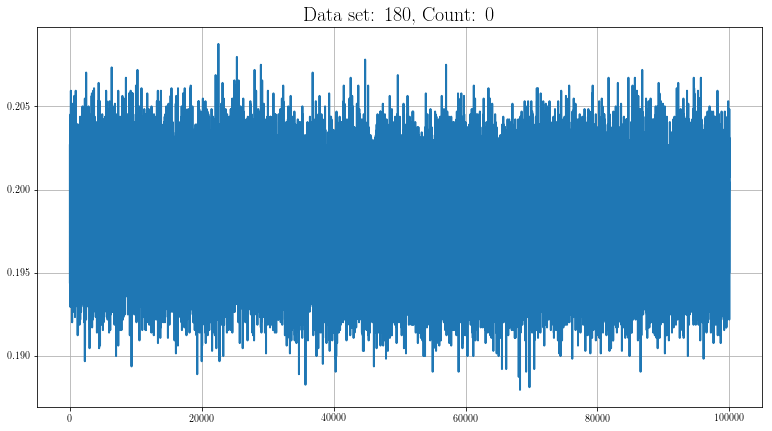

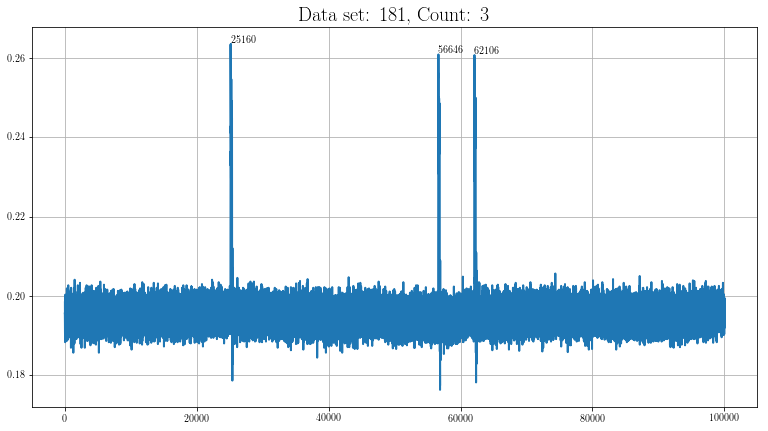

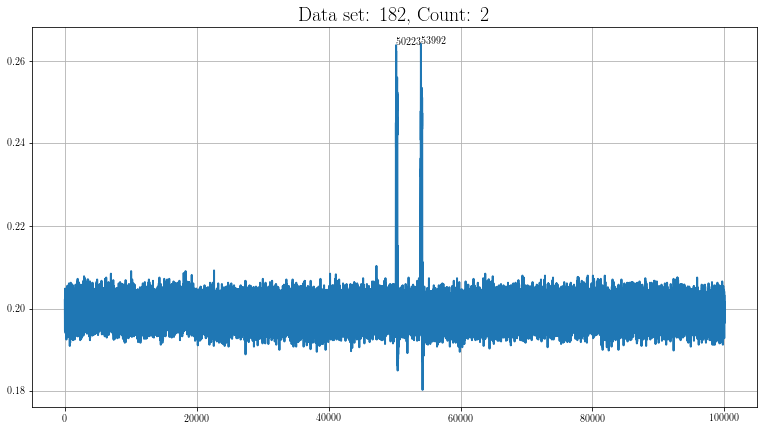

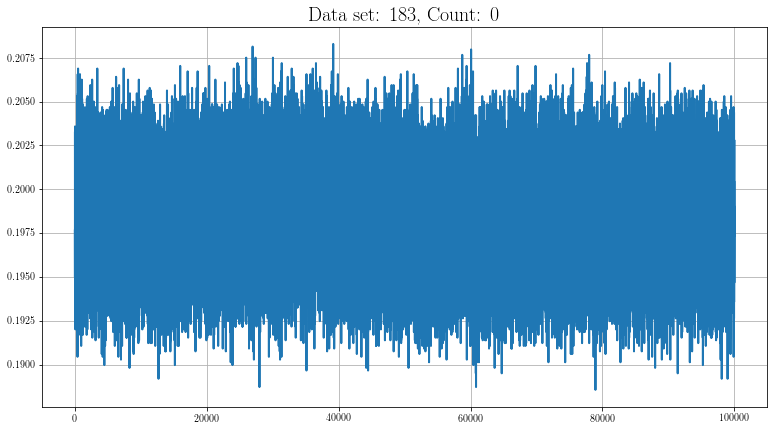

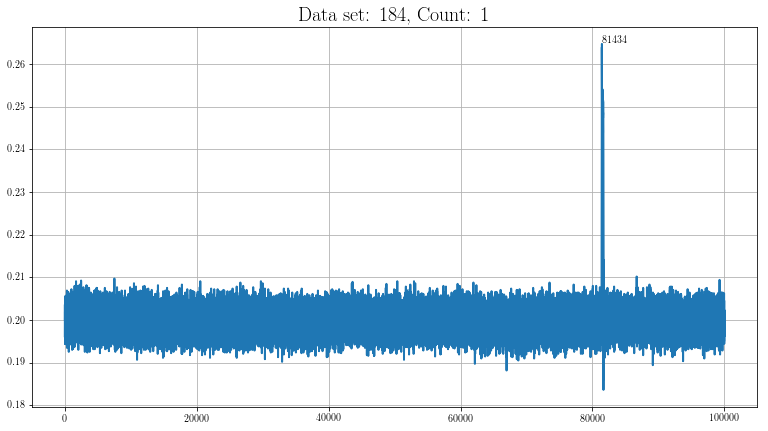

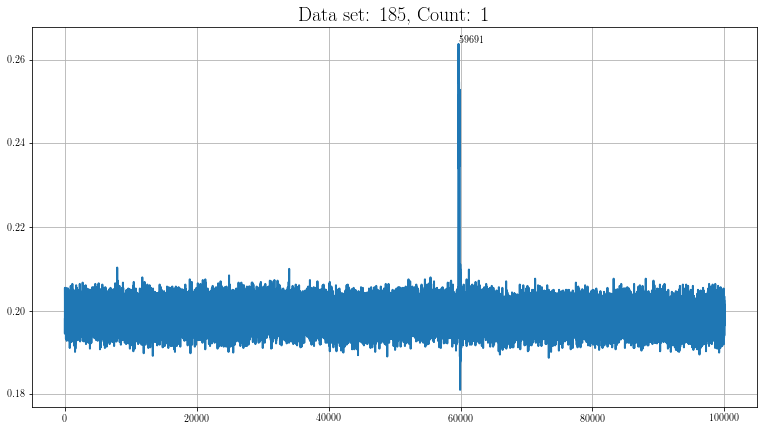

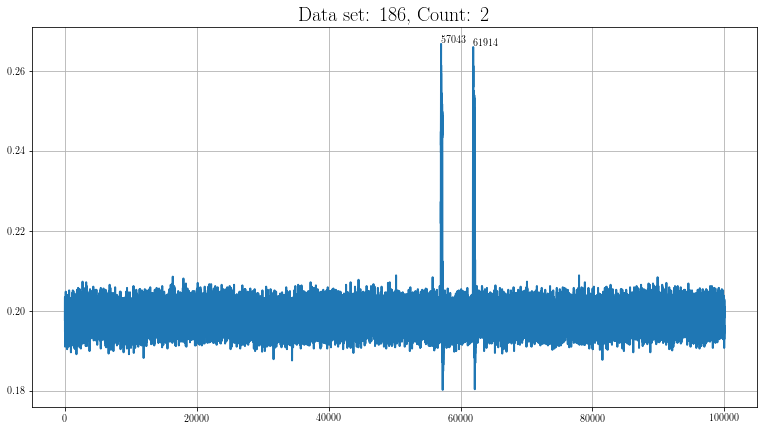

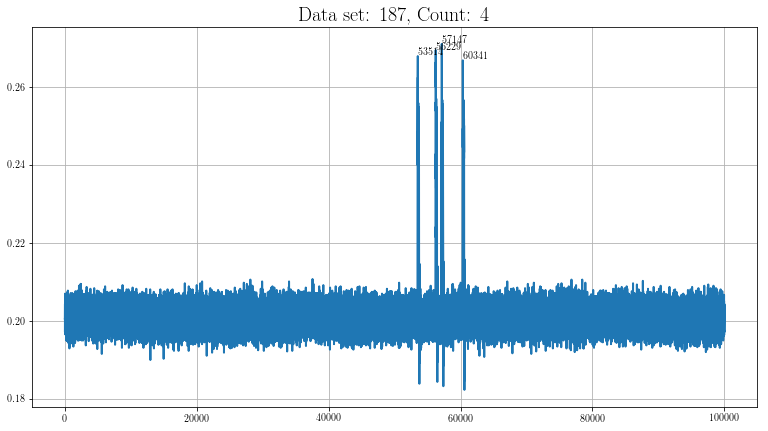

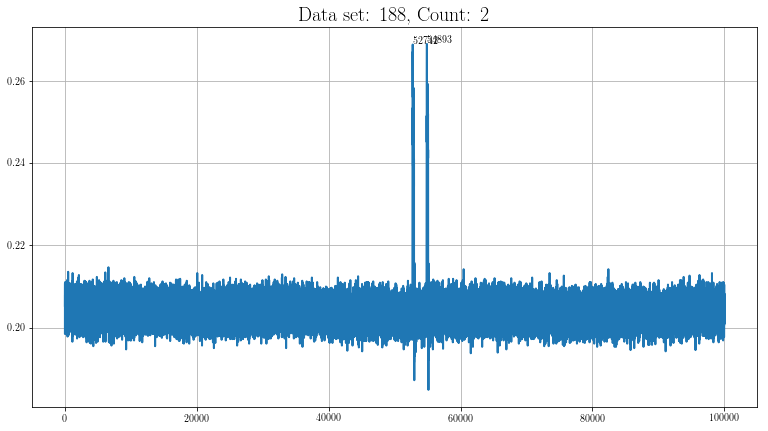

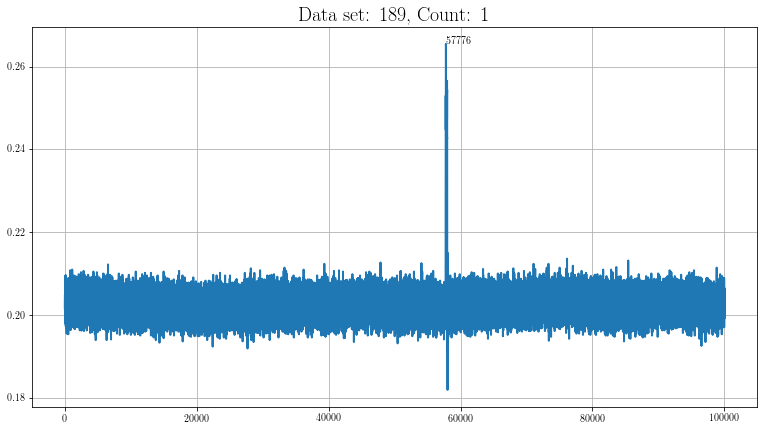

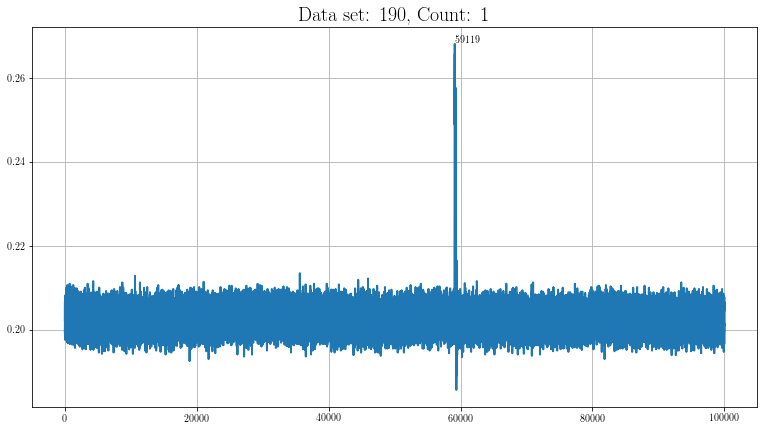

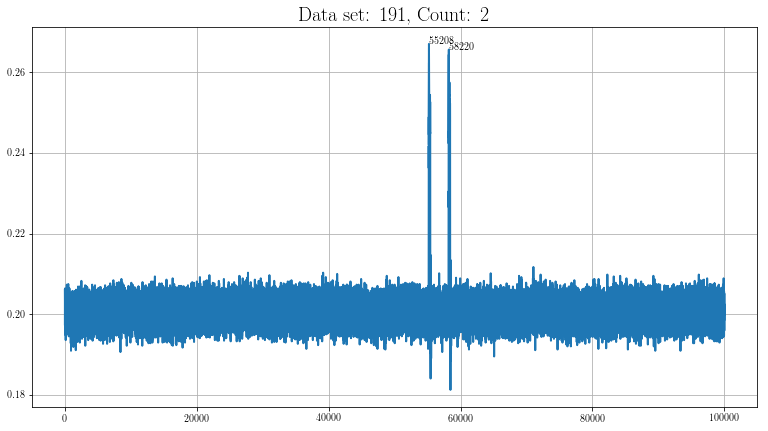

In [82]:
# This cell only needs to be run as a visual check for the accuracy of the peak identification. 

for value in range(len(data)):
    y = data[value]['ch3']
    peaks, properties = find_peaks(y, prominence=0.05, width=60, distance=30)
    fig, ax = plt.subplots(figsize=(13, 7))
    x = range(len(data[value]))
    count = len(peaks)
    ax.plot(x, y)
    ax.set_title(f'Data set: {value}, Count: {count}')
    ax.grid(True)
    for i in peaks:
        ax.text(i, data[value]['ch3'].iloc[i], i)
    plt.show()
    peaks, properties